#### Motivation
Integrating artificial intelligence into medical research requires interdisciplinary collaborations, which imposes a barrier to early phase clinical studies or work by junior researcher. Two publications by Panch, T.(2019) and Rajkomar, A (2023) published in BMC Medicine, reiterated the difficulties in assembling clinical and machine learning experts for early phase project. Conducting robust efficacy and safety evaluation is more difficult with artificial intelligence [5,10].
##### Project Template
My chosen template is CM3050 Machine Learning and Neural Networks on “Deep Learning of a public dataset”.

Objectives:
- A simple jupyter notebook-based pipeline.
- Allow import of edf files. This allows import from EEG machine.
- Preprocessing includes segmenting time series, and value standardisation.
- Implementing two algorithms, a neural network and a non-neural network based algorithm.


#### Data source
[CHB-Mit Seizure Dataset.](https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset/data)

In [3]:
# Array and file access libraries
import numpy as np
import os
from matplotlib import pyplot as plt

In [4]:
from scipy.signal import  welch, butter, filtfilt  # estimate signal power across all frequencies
import pywt # wavelet transformation algorithm. Python package to install is called PyWavelets

In [5]:
# Scikit-learn library for preprocessing and optimisation search algorithm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, \
    recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score


In [6]:
# machine learning tensorflow library
# base class for layers inheritance is Layer, in layers module
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import (Conv1D, Conv2D, LSTM, Bidirectional, MaxPooling1D, MaxPooling2D,Flatten, Input, Dense, Dropout, Layer, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization, MultiHeadAttention, LayerNormalization, Attention, UpSampling1D,
                                     Cropping1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.metrics import Recall, Precision, MSE
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


#### Rapid dataset prototyping
Uses CHM-MIT dataset, which has been preprocessed into Numpy arrays. Smaller size and has window segmentation of 1 second (Badea, 2021) [1].
This dataset provides
  - Non-balanced seizure and non-seizure classes in proportion of original raw data, as training and testing sample sets
  - For validation, an unbalanced and a balanced set are provided.
> Non-balanced dataset is used for this section (rapid prototyping)

In [7]:
# parse Badea's files and export to signals containing data and labels containing seizure or non seizure labels
# files in npz, numpy format

for root, dirs, files in os.walk('data'):
    for file in files:
        print(os.path.join(root, file))

# Data sampled at frequency 256 Hz from 23 channels , n samples.
# Each sample represents 1 second.
# Training, Testing , Validation data have shape (n,23,256).
# npz file may be saved with pickle if strings or complex objects are present

# load unbalanced training datasets
npz_train1 = np.load('data/eeg-seizure_train.npz', allow_pickle=True)
train_signals = npz_train1['train_signals']
train_labels = npz_train1['train_labels']
print(f"Training data (signals) have shape {train_signals.shape}")
print(f"Training labels have shape {train_labels.shape}")

# loads unbalanced validation datasets
npz_val1 = np.load('data/eeg-seizure_val.npz', allow_pickle=True)
val_signals = npz_val1['val_signals']
val_labels = npz_val1['val_labels']
print(f"Validation data (signals) have shape {val_signals.shape}")
print(f"Validation labels have shape {val_labels.shape}")

# loads unbalanced testing unbalanced datasets
npz_test1 = np.load('data/eeg-seizure_test.npz', allow_pickle=True)
test_signals = npz_test1['test_signals']
print(f"Test data (signals) have shape {test_signals.shape}")
# no test label file is available as this dataset if from a kaggle competition
print(npz_test1.keys())

# loads balanced validation datasets
npz_balanced1 = np.load('data/eeg-seizure_val_balanced.npz', allow_pickle=True)
npz_balanced1.keys()
val_balanced_signals = npz_balanced1['val_signals']
val_balanced_labels = npz_balanced1['val_labels']



data\eeg-predictive_train.npz
data\eeg-predictive_val.npz
data\eeg-predictive_val_balanced.npz
data\eeg-seizure_test.npz
data\eeg-seizure_train.npz
data\eeg-seizure_val.npz
data\eeg-seizure_val_balanced.npz
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\ANNOTATORS
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\RECORDS
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\RECORDS-WITH-SEIZURES
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\SHA256SUMS.txt
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\shoeb-icml-2010.pdf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\SUBJECT-INFO
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01-summary.txt
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_01.edf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_02.edf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_03.edf
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_03.edf.seizures
data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_04.edf
data\raw_dat

In [8]:
unique, count = np.unique(train_labels, return_counts=True)
print("unique",unique,"count",count)

print(f"train_signals' shape {train_signals.shape}, train_labels' shape {train_labels.shape}")

unique [0 1] count [29592  8074]
train_signals' shape (37666, 23, 256), train_labels' shape (37666,)


#### Normalise Dataset

In [9]:
def normalise_data(X_train: np.ndarray, X_test: np.ndarray, scaler: str = StandardScaler()) -> tuple:
    """Default to StandardScaler"""

    # Holder numpy array for normalised values
    train_norm= np.zeros(shape=(X_train.shape), dtype='float32')
    test_norm = np.zeros(shape=(X_test.shape), dtype='float32')

    # Iterate over each channel (samples, channel, features)
    for channel in range(X_train.shape[1]):  # Iterate over channels in dataset
        train_norm[:, channel, :] = scaler.fit_transform(X_train[:, channel, :])  # Fit and apply normaliser on current channel in train subset
        test_norm[:, channel, :] = scaler.transform(X_test[:, channel, :])  # Apply normaliser on current channel in test subset

    return train_norm, test_norm

In [10]:
train_signals_norm , val_signals_norm = normalise_data(train_signals, val_signals)
print(f"train_signals_norm shape: {train_signals_norm.shape}")
print(f"val_signals_norm shape: {val_signals_norm.shape}")


train_signals_norm shape: (37666, 23, 256)
val_signals_norm shape: (8071, 23, 256)


#### Dataset overview

CHB-MIT is the chosen dataset, as it has been well studied, and contains the standard 23 channels recordings typical of clinical practice recording. Chollet (2018) advocated a step wise baseline-based approach in building neural network. He argued the black box nature of neural network models have to be anchored on objective evaluation before building increasingly complex models.
Precision - "Of all model results labelled as positive, how many were true positive?
Recall - "Of all true positive instances, how many were correctly identified by model?"

CHB-MIT dataset contains 198 identified seizures over 916 hours of recordings. An unbalanced dataset. Typical seizure recordings span seconds to minutes. Assuming an average seizure recording of 1 minute each, there will be 3-4 hours of seizure recordings. This comprises less than 1% of all recordings. An algorithm that returns no seizure for any input will achieve accuracy of over 99%. Clearly recall and precision will be zero.
Conversely, predicting all samples as having seizure result in low accuracy, recall and precision scores, less than 0.01.  This sets the threshold target bar too low. A better approach would be to rely on Wang’s (2020) survey of epileptologists. A surveyed consensus among seizure experts is to accept sensitivity of 80% in automated diagnosis [30].

#### Baseline common sense comparator

Pre-processed dataset (Badea,2021)
Pre-processing the dataset is an essential, non-trivial step for training the model. For rapid prototyping, a pre-processed version of the CHB-MIT dataset created by Badea (2021) was utilised.
This dataset converted the raw data into Numpy arrays and segmented it into 1-second windows. This pre-processed dataset retains the original dataset's proportion of seizure and non-seizure samples, which was used for training and testing the base Dense Neural Network and Support Vector Machine models.
My custom extracted dataset
To better tailor the dataset for training, a custom dataset was created using a custom EdfToNpy class. This extraction resulted in a less unbalanced dataset with

10-second window segments. The custom dataset includes:
- 2606 seizure samples
- 6744 non-seizure samples
- Seizure samples comprise about 27.3% of the dataset.


| Data Set        | Prediction Type   | Recall Score | Accuracy Target |
|-----------------|-------------------|--------------|-----------------|
| 1Unbalanced Set | Predicting True   | 1            | < 1%            |
| Unbalanced Set  | Predicting False  | 0            | < 1%            |
| Custom Set      | Predicting True   | 1            | 27.3%           |
| Custom Set      | Predicting False  | 0            | 72.7%           |


#### Importing my custom 10-second window segmented dataset from 'edf_to_numpy.ipynb'
Pre-process raw CHB-MIT samples. Segment to **10-second** windows.
Performed in convert_raw.ipynb notebook and stored as **10sec_signals.npy** with corresponding binary labels (1 for seizure, 0 for no seizure) as **10sec_labels.npy**

Split data into training and testing sets

In [8]:
# import numpy datasets

path_10signal = "10sec_signals.npy"
path_10labels = "10sec_labels.npy"
train_10sec = np.load(path_10signal)
labels_10sec =  np.load(path_10labels)

unique, counts = np.unique(labels_10sec, return_counts=True)
print(f"Non-seizure: {counts[0]} samples, seizure: {counts[1]} samples")
print(f"10sec_signals' data shape is {train_10sec.shape}")
print(f"10sec_labels shape is {labels_10sec.shape}")
print(f"Proportion of seizure samples = {counts[1]/(counts[1]+counts[0]):.3}%")



Non-seizure: 6744 samples, seizure: 2606 samples
10sec_signals' data shape is (9350, 23, 2560)
10sec_labels shape is (9350,)
Proportion of seizure samples = 0.279%


In [9]:
# set random state to allow same sample each time notebook is run
train_10sec_data, test_10sec_data, train_10sec_labels, test_10sec_labels = train_test_split(
    train_10sec, labels_10sec, test_size=0.2, shuffle=True, stratify=np.ravel(labels_10sec), random_state=100)
print(f"shape of train_10sec_data: {train_10sec_data.shape}, shape of train_10sec_labels: {train_10sec_labels.shape}")
print(f"shape of test_10sec_data: {test_10sec_data.shape}, shape of test_10sec_labels: {test_10sec_labels.shape}")


shape of train_10sec_data: (7480, 23, 2560), shape of train_10sec_labels: (7480,)
shape of test_10sec_data: (1870, 23, 2560), shape of test_10sec_labels: (1870,)


#### Normalise dataset

This ensures faster convergence and numerical stability especially for neural network and support vector machine models

In [11]:
train_10sec_norm, test_10sec_norm = normalise_data(train_10sec_data, test_10sec_data)
print(f"train_10sec_norm: {train_10sec_norm.shape}")
print(f"test_10sec_norm: {test_10sec_norm.shape}")

NameError: name 'train_10sec_data' is not defined

#### Baseline models for comparison

##### Baseline Densely Connected Model
A feedforward dense neural network, also known as a fully connected neural network, is a type of artificial neural network where each neuron in one layer is connected to every neuron in the next layer. The network typically consists of an input layer, one or more hidden layers, and an output layer.

**Key Components:**
- **Input Layer:** Receives the input data.
- **Hidden Layers:** Intermediate layers that apply transformations to the inputs.
- **Output Layer:** Produces the final prediction output.

**Process Overview:**
1. **Data Preprocessing:** The raw input data is pre-processed (e.g., scaling) to prepare it for the model.
2. **Forward Propagation:** Data moves forward through the network layers, applying weights and biases to produce an output.
3. **Loss Computation:** The difference between the predicted output and the actual target is calculated using a loss function.
4. **Backpropagation:** The network adjusts its weights and biases to minimise the loss through an optimisation algorithm (e.g., Adam).
5. **Evaluation:** The model's performance is evaluated using metrics such as accuracy, mean absolute error (MAE), and recall.


In [7]:
class BaseDense:
    '''Setup dense class. Train and evaluate'''
    def __init__(self, train_data, train_labels, validation_data, validation_labels):
        self.train_data = train_data
        self.train_labels = train_labels
        self.validation_data = validation_data
        self.validation_labels = validation_labels
        self.model = None
        self.recall = None

    def train(self):
        inputs = Input(shape=self.train_data.shape[1:])
        x = Flatten()(inputs)
        x = Dense(16, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)

        callbacks_ = [ModelCheckpoint("dense_baseline.keras",
                                     save_best_only = True)]
        model.compile(optimizer='adam',loss='binary_crossentropy', metrics =['mae', 'Recall', 'Precision'])
        history = model.fit(self.train_data, self.train_labels,
                            epochs=20,
                            validation_data=(self.validation_data, self.validation_labels),
                            callbacks=callbacks_,
                            verbose=0)

        print(f"Training loss , mae , recall : {model.evaluate(self.validation_data, self.validation_labels)}")
        self.model = model
        self.recall = history.history['val_recall']

        # plot recall vs epochs
        epochs = np.arange(1, len(self.recall) + 1)
        plt.plot(epochs, self.recall,label='Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.show()

    def evaluate(self):
        # Evaluate model
        history_loss, history_mae, history_recall, history_precision = self.model.evaluate(self.validation_data, self.validation_labels)
        print(f" loss: {history_loss:.4f} , mae: {history_mae:.4f} , recall: {history_recall:.4f}, precision: {history_precision:.4f}")

        # returns array of probability (float) of binary outcome
        # convert to integer. Without astype(int) returns array of True, False
        y_pred = ( self.model.predict(self.validation_data) > 0.5 ).astype(int)
        y_true = self.validation_labels

        # print confusion matrix
        print("\n Confusion Matrix:")
        cm_labels = ['Non-seizure', 'Seizure']
        cm = confusion_matrix(y_true, y_pred)
        display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
        display_cm.plot(cmap=plt.cm.Blues)
        plt.show()

        #return true positive, and false negative for calculating recall
        return cm

    def pre_process(self):
        scalar = StandardScaler()
        # standard scaler takes 2 dimensions. Train methods take 3 dimensions data
        samples_t, channels_t, features_t = self.train_data.shape
        samples_v, channels_v, features_v = self.validation_data.shape

        temp_train = self.train_data.reshape(samples_t, channels_t * features_t)
        temp_validate = self.validation_data.reshape(samples_v, channels_v * features_v)

        temp_train = scalar.fit_transform(temp_train)
        temp_validate = scalar.transform(temp_validate)

        self.train_data = temp_train.reshape(samples_t,channels_t, features_t)
        self.validation_data = temp_validate.reshape(samples_v,channels_v, features_v)




253/253 [==============================] - 2s 9ms/step - loss: 0.7139 - mae: 0.1812 - recall: 0.5454 - precision: 0.6786
Training loss , mae , recall : [0.7138923406600952, 0.18116743862628937, 0.545403242111206, 0.6785964965820312]


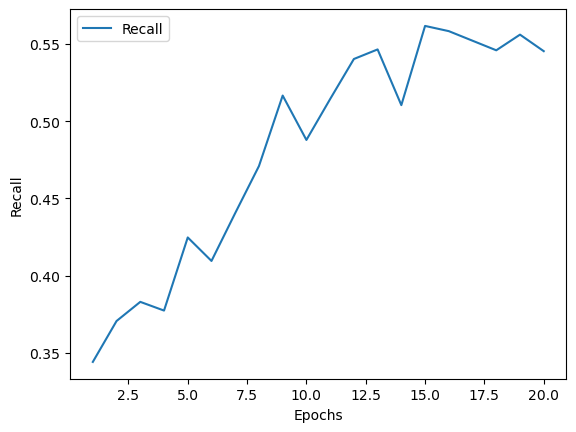

In [8]:
# Training on training data
base_nn = BaseDense(train_signals,train_labels,val_signals,val_labels)
base_nn.pre_process()  # convert data to hve mean=0, standard deviation=1. Leads to quicker converge during training
base_nn.train()



253/253 [==============================] - 2s 8ms/step - loss: 0.7139 - mae: 0.1812 - recall: 0.5454 - precision: 0.6786
 loss: 0.7139 , mae: 0.1812 , recall: 0.5454, precision: 0.6786
253/253 [==============================] - 2s 8ms/step

 Confusion Matrix:


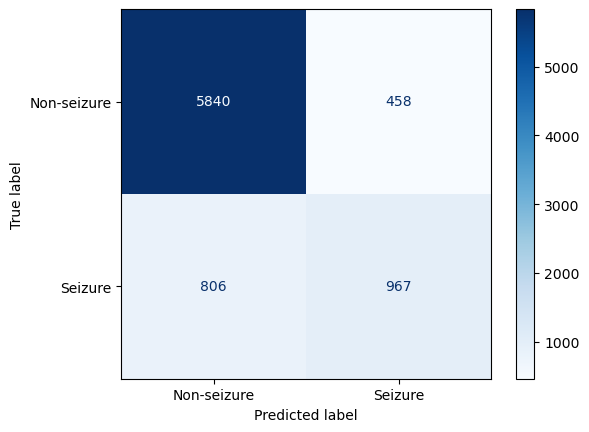

array([[5840,  458],
       [ 806,  967]], dtype=int64)

In [9]:
# Evaluating on validation data, returns confusion matrix [[true negative,false positive],[false negative, true positive]]
base_nn.evaluate()

> Basic simple dense neural network achieves recall around 56% on 1-second sampling data provided by Badea (2021).

#### Baseline comparitor using Support Vector Machine classiifier

##### Wang (2011) showed use of bandpass filter and wavelet analysis to train SVM seizure classifier [29] with good accuracy
Wavelet analysis is a mathematical signal transformation which is localised in frequency and time. Wavelet analysis uses such wavelets to perform mathematical transformation.

 1. Brain EEG signal of > 50 Hz often associated with eye movement, muscle activities etc
 2. Brain EEG signal < 1 Hz are general slow drifts in records.
 3. Useful brain activity often around 1 - 30+ Hz


Class SVM_Tools contains seven methods:
1. train_svm(data,label) -> SVM classifier trained on CHB-MIT seizure data of samples size (37666,23,256). A static method
2. get_psd(self,data_signal, frequency=256, segment_length=256)  -> numpy array of power signal density features. Unable to run CHB-MIT dataset in a single process. Numpy array size is too large to fit into memory.
3. get_psd_batch(self, batch_size=1000) -> numpy array of power signal features. Run get_psd in batches.
4. def to_svm_input(data_signal) -> numpy array with dimensions (n_samples, n_features) , where n_samples represents number of samples and n_features represents number of features, obtain by converting (n_samples, n_channels, n_datapoints) into (n_samples , n_channels x n_datapoints). This is the shape required for SVM training. A static method.
5. show_shape(self) -> returns shape of input data
6. get_wavelet(self, scales=np.arange(1,30), wavelet='cmor') -> returns np.ndarray of shape (n_samples, n_features)
7. a cache decorator. see section on caching, three cells below.

#### Feature extraction implemented.
Training SVM model on dataset with more than 36000 samples takes prohibitively long on my machine during rapid prototyping phase.
In first iterative phase, feature extraction feature is added to allow computation in reasonable time.
Literature review showed wavelet analysis and power spectral analysis are two possible feature extraction methods [29].
Wavelet analysis:
- extracts time-frequency representation
- requires higher computation resource

#### Power spectral analysis:
- analyse only frequency domain.
- lower computation resource needed.
- estimate using Welch method: divides data into overlapping segments, computing a modified periodogram for each segment. Then average the periodograms.



One way to understand **wavelet** transform is to consider two steps:

Step 1: Transform the signal using wavelet mathematical functions that are localized in time and frequency. Think of an oscilloscope analysing a range of frequencies from a sound signal. The same oscilloscope is turned on and off at fixed interval. We know have a frequency-time representation of the input ssound creating a time-frequency representation of the signal.

Step 2: Scale the wavelet (stretch/compress the signal on the oscilloscope) to analyze different frequency bands (high scales (stretch signal) = low frequencies, low scales (compress signal) = high frequencies). At the same time while translating (shifting) it across different range of frequencies to capture how the signal evolves over time (think of zooming in for increased resolution or zooming out for more panoramic view ). The range of scales is specified as numpy array  : np.arange(1,30) means about 30 different 'sizes' of frequency range applied.

A way to visualise this is by imagining a wavelet function that starts out narrow (high frequency) and becomes wider (low frequency). By applying it at different scales , you zoom in and out to capture the frequency components at different levels of detail.

If still confusing - think of wavelet transformation as compressing frequency and time into a fewer numbers but representative of time-frequency information. Analogous to how mean is representative a series of integers!

##### Standardisation of input data
Input values are standardised to mean of 0 and standard deviation of 1.
1. Support Vector Machine algorithm is sensitive to scale of input, and perform  better with standardised data.
2. Ensures all features contribute equally by putting them onto a common scale.
3. Helps gradient based algorithm to converge quicker.

#### Caching
Wavelet and PSD preprocessing takes some time. Therefore, it makes sense to cache the results for efficiency.

In-built 'lre-cache' requires hashable input. Arrays have to be converted to hashable format, such as a tuple, using tuple(numpy array). This consumes memory and computation resource.

Since there are few but very large arrays to store in this programme, use of python dictionary is more efficient. Hashing is not necessary, as key name lookup for so few arrays are sufficiently efficient.

cache_decorator is implemented as a decorator. Arrays are cached as simple name-value pairs in cache_dictionary inside SVN_Tools.


In [7]:
class SVMClassifier:
    def __init__(self, data, labels, kernel='rbf', random_state=42):
        self.kernel = kernel
        self.random_state = random_state
        self.model = SVC(kernel=self.kernel, random_state=self.random_state)
        self.scaler = StandardScaler()
        self.train_signals = self.bandpass_filter(data)
        self.train_signals = self.scale_features(self.train_signals)
        self.features = ''
        self.labels = labels  # Labels don't require filtering


    def bandpass_filter(self, data, low_hz=1, high_hz=50, sampling_frequency=256, order=4):
        """
        # useful brain activity 1 - 50 Hz
        # apply band filter. Remove > 50 Hz, and < 1 Hz frequencies
        # Nyquist frequency is twice the frequency that can be reconstituted from data
        # parameters to create filter using butter function from scipy.signal
        """
        nyquist = 0.5 * sampling_frequency
        low = low_hz / nyquist
        high = high_hz / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data, axis=-1)


    def scale_features(self, data):
        """
        Scales the train_signals to have zero mean and unit variance.
        Assumes data shape is (samples, channels, datapoints).
        """
        n_samples, n_channels, n_datapoints = data.shape
        data_reshaped = data.reshape(n_samples, -1)  # Flatten channels and datapoints
        scaled_data = self.scaler.fit_transform(data_reshaped)  # Scale using StandardScaler
        return scaled_data.reshape(n_samples, n_channels, n_datapoints)  # Reshape back to original shape


    def get_psd_features(self, data, save_to='', sampling_frequency=256):
        if save_to:
            save_to =  'psd_features.csv' + save_to
        if save_to and os.path.exists(save_to):
            print("PSD features already exist. Loading from file.")
            return np.loadtxt(save_to, delimiter=',')



        n_samples, n_channels, n_datapoints = data.shape
        psd_features = []

        for sample in range(n_samples):
            sample_features = []
            for channel in range(n_channels):
                freqs, psd = welch(data[sample, channel], fs=sampling_frequency, nperseg=256)
                sample_features.append(psd)
            psd_features.append(np.concatenate(sample_features))

        psd_features = np.array(psd_features)
        if save_to:
            np.savetxt(save_to, psd_features, delimiter=',')

        self.feature = psd_features
        return psd_features


    # 'cmor' stands for Complex Morlet wavelet, common algorithm  for time-series wavelet analysis built into python wavelet transform module (pywt)
    # 'cmor1.5-1.0' means Complex Morlet wave with bandwidth frequency 1.5 and centre frequency 1.0
    def get_wavelet_features(self, data, scales=np.arange(1,30), wavelet='cmor1.5-1.0', save_to='')-> np.ndarray:
        if save_to:
            save_to =  'wavelet_features_' + save_to + '.csv'
        if save_to and os.path.exists(save_to):
            print("Wavelet features already exist. Loading from file.")
            wavelet_features = np.loadtxt(save_to, delimiter=',')
            self.features = wavelet_features  # Ensure the features attribute is updated
            return wavelet_features

        n_samples, n_channels, n_datapoints = data.shape
        wavelet_features = []

        for sample in range(n_samples):
            sample_features = []
            for channel in range(n_channels):
                coeffs, _ = pywt.cwt(data[sample, channel], scales, wavelet)
                power = np.abs(coeffs) ** 2
                mean_power = np.mean(power, axis=1)
                sample_features.append(mean_power)
            wavelet_features.append(np.concatenate(sample_features))

        wavelet_features = np.array(wavelet_features)
        if save_to:
            np.savetxt(save_to, wavelet_features, delimiter=',')

        self.features = wavelet_features  # Ensure the features attribute is updated
        print("Wavelet features shape:", self.features.shape) # Debugging line
        return wavelet_features

    def parameter_tuning(self, features, labels, param_grid, cv=3):
        grid_search = GridSearchCV(SVC(random_state=self.random_state), param_grid, cv=cv, n_jobs=-1)
        grid_search.fit(features, labels)
        print("Best parameters found:", grid_search.best_params_)
        self.model = grid_search.best_estimator_
        return grid_search.best_params_

    def train_and_evaluate(self, test_size=0.2):
        # Check features are available
        if self.features.shape[0] == 0:
            raise ValueError("Features not populated. Please run a feature extraction method like get_wavelet_features first.")

        X_train, X_test, y_train, y_test = train_test_split(self.features, self.labels, test_size=test_size, random_state=self.random_state)
        self.model.fit(X_train, y_train)
        predictions = self.model.predict(X_test)

        accuracy = accuracy_score(y_test, predictions)
        report = classification_report(y_test, predictions)
        return accuracy, report


    def evaluate(self,test_data, test_labels):
        """
        Evaluate using separate data not seen during training to prevent data leaks
        """
        # pre-process to keep 1 -50 Hz frequency
        test_data = self.bandpass_filter(test_data)
        # pre-process to  normalised data
        test_data = self.scale_features(test_data)
        # SVC model from sklearn takes 2 dimensions input or less
        # reshape to keep last dimension value from input test_data.shape[-1]
        # -1 argument in reshape tells numpy to auto-calculate dimensions.
        test_data = test_data.reshape(-1, test_data.shape[-1])
        # predict on new data
        predictions = self.model.predict(test_data)
        # compare to test labels
        accuracy = accuracy_score(test_labels, predictions)
        # print evaluation metrics
        report = classification_report(test_labels, predictions)
        return accuracy, report


#### Implemented coding techniques
Efforts have been taken emphasising code reuse, error handling, robustness, interoperability and scalability .
These are steps taken in SVM_Tools class.

1. Code reuse: Pre-processing tool like PSD, WA, and training, cross validation steps are defined as separate methods inside SVM_Tools class. A
2. Improve data handling resilience through input data dimensions and type validations. Example: validate_data method.
3. Improve memory efficiency by caching large arrays, such as wavelet analysis outputs, instead of repeating calculations whenever wavelet transformation of data is needed. Example: get_wavelet method.
4. Improve CPU efficiency with parallel processing. RandomSearchCV, when n_jobs set to -1 uses maximal cores.
5. Testing, such as unit test custom methods for input types, boundary cases improves code robustness. This is perform separately in notebook “test_svm_tools.ipynb”. Notebook instead of single python file is chosen for ease of markings, and consistency in submitted file types.
Example: tst_svm_toolss.ipynb – unit test ensuring correct dimensions, and type for get_psd, get_wavelet methods. Unit test for successful caching and retrieval for cache_decorators method.
6. Modularity and scalability is achieved by breaking codes into different methods in a common class.
7. Save files to common formats such as npy or csv, for ease interoperability.

Potential works for next iteration
 - 	Break get_wavelet method. Currently method does filter and wavelet analysis. Best practice requires a method to address a single concern. ‘get_wavelet’ could be broken into filter and wavelet analysis
 -	Speed up time consuming ‘get_wavelet’ function could be achieved with parallel processing. Joblib library is a good option to recode this function for parallel processing


Classes available:
1. BaseDense class for setting up, training and evaluating neural network using dense layer from tensorflow library.
2. SVM_Tools class for setting up, training and evaluating support vector machine classifier from sklearn library.
3. EdfToNpy class is available to convert edf format to numpy readable format in file convert_raw.ipynb.

##### Instantiate SVM class and model training

1-second window segmented EEG is stored in:
- `train_signals` for training data
- `train_labels` for training labels

10-second window segmented EEG is stored in:
- `train_signals_10s` for training data
- `train_labels_10s` for training labels
-  labels contain 6744 non-seizure samples and 2606 seizure samples (27.3%).


In [8]:
# 1 second window train_signals, train_labels, 10-second segmentation window: train_signals_10s, and train_labels_10s
# CHB-MIT has sampling rate of 256Hz. Brain waves range from 1 - 50 H
# Band filter applied during initialisation of SVMClassifier
svm_1s_model = SVMClassifier(train_signals, train_labels)
#svm_10s_model = SVMClassifier(train_10sec, labels_10sec)

In [9]:
# wavelet features is automatically saved to 'wavelet_features.csv'
# as computation takes 20+ minutes, when present wavelet_features are downloaded from wavelet_features.csv
svm_1s_model.get_wavelet_features(train_signals, save_to='1')

Wavelet features shape: (37666, 667)


array([[3.95918764e-01, 2.23869770e-01, 6.10945805e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.61898934e-01, 4.39053812e-01, 8.87175117e+00, ...,
        4.86170458e+01, 6.10267863e+01, 7.61064999e+01],
       [4.04894754e+01, 1.45023982e+02, 2.54028613e+02, ...,
        4.67449069e+03, 4.80829150e+03, 4.86971080e+03],
       ...,
       [8.66257499e-01, 1.37844828e+00, 1.08708613e+01, ...,
        1.15924392e+02, 1.01093234e+02, 8.74552952e+01],
       [2.81597143e-01, 3.44721729e-01, 1.90219295e+00, ...,
        4.94887095e+02, 5.28643619e+02, 5.68043741e+02],
       [1.59945976e-01, 3.84702690e-01, 6.66970564e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [38]:
print("\n--- Wavelet Features (1-second window) ---")
wavelet_accuracy_1s, wavelet_report_1s = svm_1s_model.train_and_evaluate()
print(f"Training dataset- Accuracy: {wavelet_accuracy_1s:.4f}\n{wavelet_report_1s}")


--- Wavelet Features (1-second window) ---
Training dataset- Accuracy: 0.8490
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      5972
           1       0.83      0.34      0.49      1562

    accuracy                           0.85      7534
   macro avg       0.84      0.66      0.70      7534
weighted avg       0.85      0.85      0.82      7534



"*train_wavelet*" stores wavelet transformed train_signals.

"*train_labels*"  stores corresponding seizure labels.

**Train Support Vector Machine Classifier**

 >Baseline SVM model using C=1, kernel='linear' achieve a recall score of 34% for seizure detection

In [10]:
# def normalise_data(X_train: np.ndarray, X_test: np.ndarray, scaler: str = StandardScaler()) -> tuple:
#     """Default to MinMaxScaler"""
#
#     # Holder numpy array for normalised values
#     test_norm= np.zeros(shape=(X_train.shape), dtype='float32')
#     test_10sec_norm = np.zeros(shape=(X_test.shape), dtype='float32')
#
#     # Iterate over each channel (samples, channel, features)
#     for channel in range(X_train.shape[1]):  # Iterate over channels in dataset
#         train_10sec_norm[:, channel, :] = scaler.fit_transform(X_train[:, channel, :])  # Fit and apply normaliser on current channel in train subset
#         test_10sec_norm[:, channel, :] = scaler.transform(X_test[:, channel, :])  # Apply normaliser on current channel in test subset
#
#     return train_10sec_norm, test_10sec_norm


#### Common sense baseline

This 10-sec window dataset contains 116 seizure samples and 9413 non-seizure samples. 0.0123% are seizure samples.

> Target sensitivity or recall of 80%


#### Baseline using dense neural network and 10-second window

111/111 [==============================] - 4s 34ms/step - loss: 3.6283 - mae: 0.3435 - recall: 0.3560 - precision: 0.3896
Training loss , mae , recall : [3.6282804012298584, 0.3435359001159668, 0.35598376393318176, 0.38956713676452637]


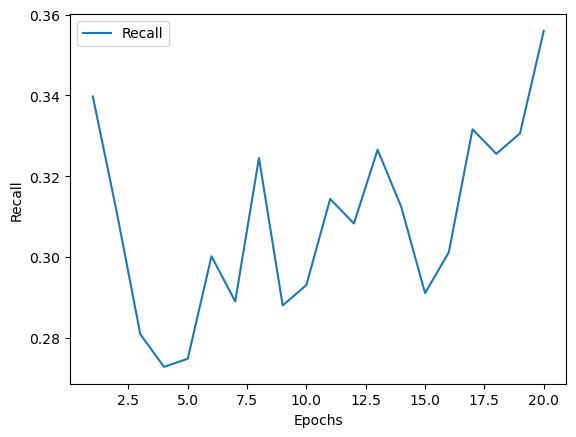

In [12]:
nn_10sec = BaseDense(train_10sec_data, train_10sec_labels, test_10sec_data, test_10sec_labels)
# standardise data range
# pre-process standard scaler is method built into BaseDense class by calling pre_process
nn_10sec.pre_process()
nn_10sec.train()

111/111 [==============================] - 4s 39ms/step - loss: 3.6283 - mae: 0.3435 - recall: 0.3560 - precision: 0.3896
 loss: 3.6283 , mae: 0.3435 , recall: 0.3560, precision: 0.3896
111/111 [==============================] - 4s 38ms/step

 Confusion Matrix:


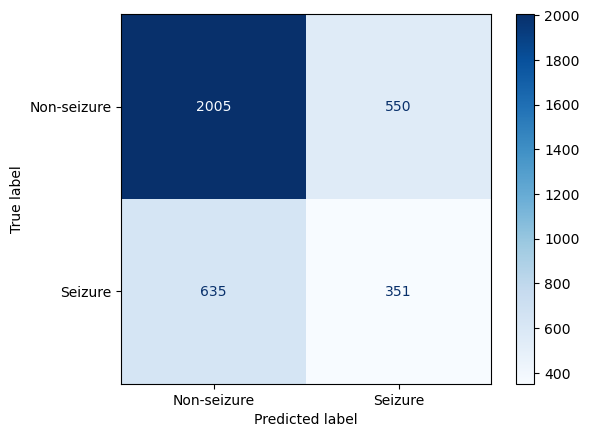

array([[2005,  550],
       [ 635,  351]], dtype=int64)

In [13]:
# test set comprises 30% of full set
nn_10sec.evaluate()

#### Dense Layer Neural Network Model
I have implemented the 10-second window segmentation class in a separate notebook: *convert_raw.ipynb*. This pushes the recall value beyond the target of 80%, as suggested by Wang.

Increasing the window size from 1 to 10 seconds, as proposed by Alzahy (2019) [4], however leads to a
> drop in recall from **0.56** to **0.25**.

- In the 1-second dataset, of 29,592 total samples, **27%** are seizure positive.
- In the 10-second dataset, of 11,802 total samples, **38%** are seizure positive

***Explanations***

1. It is easier to discriminate a smaller seizure subset from larger samples than a smaller seizure subset in a smaller pool.
2. 10-second samples are more complex to learn from. However, this mimics real-world seizures better than 1-second EEG samples.

***Steps for Next Iteration***
1. Longer training (currently, epochs = 20)
2. Parameter tuning. This step is delayed until the latter part of the project to expedite building early models.
3. Cross-validation to achieve consistency across different subsets.
4. Use more balanced 10-second samples.
5. Feature extraction for better discrimination. This applies better to non-neural network models. Will apply to Support Vector Machine model.
6. For neural network models, will use convolution and Long Short-Term Memory models to help auto-learn features and fit

#### SVM model trained on 10-second window segmented data

In [13]:
svm_10s_model = SVMClassifier(train_10sec, labels_10sec)

In [14]:
svm_10s_model.get_wavelet_features(train_10sec,save_to='10')

Wavelet features shape: (11802, 667)


array([[  5.097238 ,   4.6018906,  35.891907 , ..., 413.33472  ,
        482.81622  , 560.7572   ],
       [  2.3305485,   1.9077858,  14.53631  , ..., 306.33936  ,
        330.71384  , 358.83575  ],
       [  8.044469 ,  14.519121 ,  94.11857  , ..., 691.394    ,
        699.57874  , 720.76337  ],
       ...,
       [  1.5026666,   5.434125 ,   9.957453 , ..., 347.41565  ,
        384.9178   , 427.09317  ],
       [  1.0748962,   1.0056086,   5.208766 , ..., 639.83264  ,
        688.69727  , 731.94885  ],
       [  1.1298566,   2.1076827,   8.9242325, ..., 778.3595   ,
        883.25916  , 982.66064  ]], dtype=float32)

In [45]:
print("\n--- Wavelet Features (10-second window) ---")
wavelet_accuracy_10s, wavelet_report_10s = svm_10s_model.train_and_evaluate()
print(f"Accuracy: {wavelet_accuracy_10s:.4f}\n{wavelet_report_10s}")


--- Wavelet Features (1-second window) ---
Accuracy: 0.8263
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1750
           1       0.88      0.38      0.53       611

    accuracy                           0.83      2361
   macro avg       0.85      0.68      0.71      2361
weighted avg       0.83      0.83      0.80      2361



#### Comparing 1-second vs 10-second segmentation of CHG-MIT dataset

| Segmentation | Precision | Recall |
|--------------|-----------|--------|
| 1-second window | 0.83 | 0.34 |
| 10-second window | 0.88 | 0.38 |


> There is **12%** (rounded) increase in recall score using my own 10-second window segmented CHB-MIT EEG dataset.



#### Bi-LSTM model

The bidirectional LSTM architecture implemented follows Deepa’s design (2022).
It consists of 3 bidirectional layers,
 - Bidirectional LSTM with 128 neurons
 - Dropout layer with ratio 0.3
 - Bidirectional LSTM with 64 neurons
 - Dropout layer with ratio 0.3
 - Bidirectional LSTM with 32 neurons
 - Dense binary classification layer with sigmoid activation function.




In [6]:


class RnnModel:
    def __init__(self, train_signals, train_labels, test_signals, test_labels):
        self.train_signals = train_signals
        self.train_labels = train_labels
        self.test_signals = test_signals
        self.test_labels = test_labels
        self.model = None
        self.recall = None

    def train(self):
        # Instantiate sequential API
        model = Sequential()

        timesteps = self.train_signals.shape[1]
        features = self.train_signals.shape[2]

        # Add first Bidirectional LSTM layer
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(timesteps, features)))
        # Add dropout to prevent overfitting
        model.add(Dropout(0.3))

        # Add second Bidirectional LSTM layer
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        # Add dropout to prevent overfitting
        model.add(Dropout(0.3))

        # Add third Bidirectional LSTM layer
        model.add(Bidirectional(LSTM(32)))

        # Output layer with 1 neuron and sigmoid activation for binary classification
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model with binary cross-entropy loss and Adam optimizer
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall', 'Precision'])

        history = model.fit(self.train_signals, self.train_labels, epochs=10, batch_size=64, validation_split=0.3)
        self.model = model
        self.recall = history.history['val_recall']

        # plot recall vs epochs graph
        epochs = range(1,len(self.recall)+1)
        recall = self.recall
        plt.plot(epochs, recall)
        plt.ylabel('Recall')
        plt.xlabel('Epochs')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def evaluate(self):
        loss, recall, precision  = self.model.evaluate(self.test_signals, self.test_labels)
        print(f"Test loss : {loss:.4f} , Test Recall : {recall:.4f} , Test Precision : {precision:.4f}")

        #prediction
        y_prediction = ( self.model.predict(self.test_signals) >0.5).astype(int)
        y_true = self.test_labels

        # plot confusion matrix
        cm = confusion_matrix(y_true, y_prediction)
        cm_labels = ["Non-seizure", "Seizure" ]
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels).plot(cmap=plt.cm.Blues)
        plt.title('Test set: Confusion Matrix')
        plt.show()




In [9]:
bilstm = RnnModel(train_10sec_data, train_10sec_labels, test_10sec_data, test_10sec_labels)
bilstm.train()


Epoch 1/10
91/91 [==============================] - 75s 699ms/step - loss: 0.0625 - recall: 0.9556 - precision: 0.9556 - val_loss: 0.0052 - val_recall: 0.9773 - val_precision: 0.9773
Epoch 2/10
91/91 [==============================] - 61s 672ms/step - loss: 0.0019 - recall: 1.0000 - precision: 0.9677 - val_loss: 0.0070 - val_recall: 0.9091 - val_precision: 0.9756
Epoch 3/10
91/91 [==============================] - 59s 653ms/step - loss: 4.1719e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0049 - val_recall: 0.9545 - val_precision: 0.9767
Epoch 4/10
91/91 [==============================] - 60s 665ms/step - loss: 2.0143e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0048 - val_recall: 0.9545 - val_precision: 0.9767
Epoch 5/10
91/91 [==============================] - 60s 658ms/step - loss: 1.2856e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0052 - val_recall: 0.9545 - val_precision: 0.9767
Epoch 6/10
91/91 [==============================] - 60s 660ms/step - loss

111/111 [==============================] - 18s 156ms/step - loss: 0.0041 - recall: 1.0000 - precision: 0.9636
Test loss : 0.0041 , Test Recall : 1.0000 , Test Precision : 0.9636
111/111 [==============================] - 19s 169ms/step


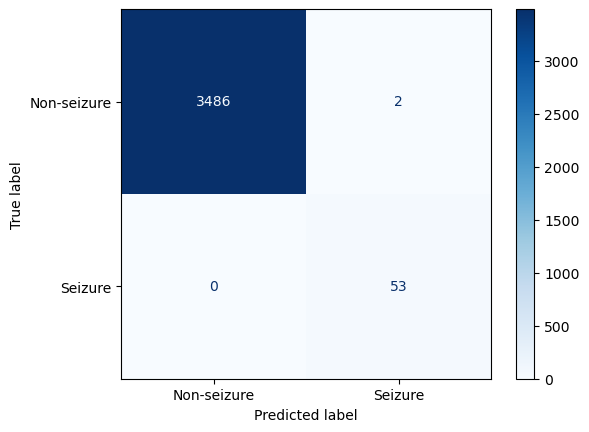

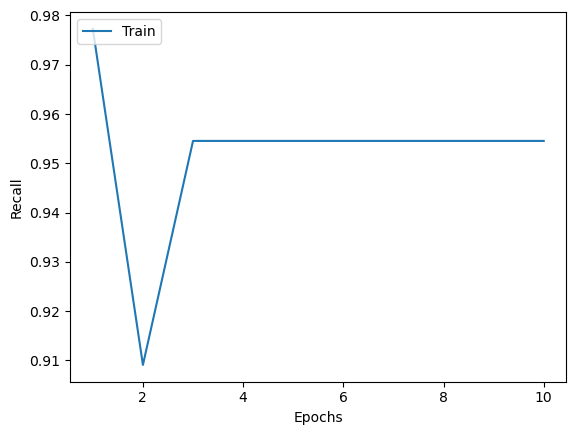

In [11]:
bilstm.evaluate()

> During training recall score is **0.9545** and precision is **0.9767** on validation set

> Evaluating on reserved test (not used during training) gives recall score of  **1.0000** , and precision of **0.9636**
>
> Conclusion, high recall score on training validation and test set provides confidence we are able to achieve recall target of **0.8** or 80%


In [15]:
# Reattempt with 1 second data
sec1_model  = RnnModel(train_signals,train_labels, val_signals,val_labels)
sec1_model.train()


Epoch 1/10
412/412 [==============================] - 60s 125ms/step - loss: 0.4673 - recall: 0.1754 - precision: 0.6271 - val_loss: 0.4491 - val_recall: 0.2640 - val_precision: 0.6643
Epoch 2/10
412/412 [==============================] - 47s 114ms/step - loss: 0.4354 - recall: 0.2880 - precision: 0.6976 - val_loss: 0.4411 - val_recall: 0.2447 - val_precision: 0.7095
Epoch 3/10
412/412 [==============================] - 46s 112ms/step - loss: 0.4164 - recall: 0.3207 - precision: 0.7206 - val_loss: 0.4293 - val_recall: 0.3132 - val_precision: 0.6717
Epoch 4/10
412/412 [==============================] - 46s 113ms/step - loss: 0.4034 - recall: 0.3546 - precision: 0.7440 - val_loss: 0.4256 - val_recall: 0.2574 - val_precision: 0.7333
Epoch 5/10
412/412 [==============================] - 47s 114ms/step - loss: 0.3888 - recall: 0.3835 - precision: 0.7499 - val_loss: 0.4270 - val_recall: 0.2952 - val_precision: 0.7337
Epoch 6/10
412/412 [==============================] - 47s 115ms/step - loss

253/253 [==============================] - 7s 26ms/step - loss: 0.4307 - recall: 0.3886 - precision: 0.6709
Test loss : 0.4307 , Test Recall : 0.3886 , Test Precision : 0.6709
253/253 [==============================] - 8s 25ms/step


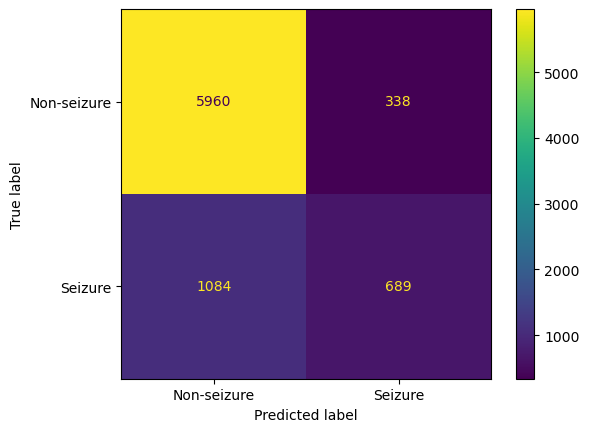

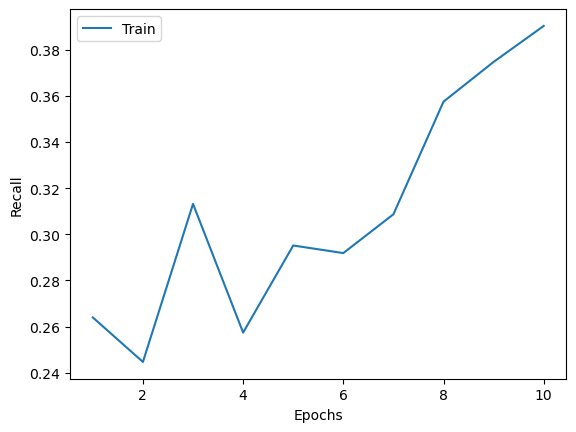

In [17]:
sec1_model.evaluate()

In [12]:
class PrototypeModel:
    """
    Convolutional Long Short-Term Memory Network
    """
    def __init__(self, train_signals, train_labels, test_signals, test_labels):
        self.train_signals = train_signals
        self.train_labels = train_labels
        self.test_signals = test_signals
        self.test_labels = test_labels
        self.model = None
        self.recall = None

    def hybrid(self):
        model = Sequential()
        # First convolutional layer
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=self.train_signals.shape[1:]))
        model.add(MaxPooling1D(pool_size=2))

        # Second convolutional layer
        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

        # LSTM layer
        model.add(LSTM(128, activation='relu', return_sequences=False))

        # Output layer for binary classification
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Recall', 'Precision'])
        model.summary()

        return model

    def train(self):
        # Instantiate and train the model
        self.model = self.hybrid()
        history = self.model.fit(self.train_signals, self.train_labels, epochs=10, batch_size=64, validation_split=0.3)
        self.recall = history.history['val_recall']

        # plot training recall score vs epochs
        epochs = range(1, len(self.recall) + 1)
        recall = self.recall
        plt.plot(epochs, recall)
        plt.ylabel('Recall')
        plt.xlabel('Epochs')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def evaluate(self):
        # Evaluate the model on the test set
        loss, recall, precision = self.model.evaluate(self.test_signals, self.test_labels)
        print(f"Test loss: {loss:.4f}, Test Recall: {recall:.4f}, Test Precision: {precision:.4f}")

        # Generate predictions
        y_prediction = (self.model.predict(self.test_signals) > 0.5).astype(int)
        y_true = self.test_labels

        # Plot confusion matrix
        cm = confusion_matrix(y_true, y_prediction)
        cm_labels = ["Non-seizure", "Seizure"]
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels).plot(cmap=plt.cm.Blues)
        plt.show()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 21, 64)            491584    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 8, 128)            24704     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 4, 128)           0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 1)                

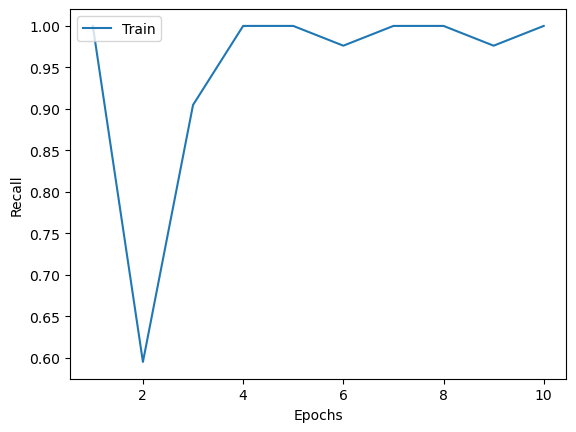

In [20]:
conv_lstm = PrototypeModel(train_10sec_data, train_10sec_labels, test_10sec_data, test_10sec_labels)
conv_lstm.train()

111/111 [==============================] - 3s 25ms/step - loss: 0.7142 - recall: 1.0000 - precision: 0.9818
Test loss: 0.7142, Test Recall: 1.0000, Test Precision: 0.9818
111/111 [==============================] - 3s 26ms/step


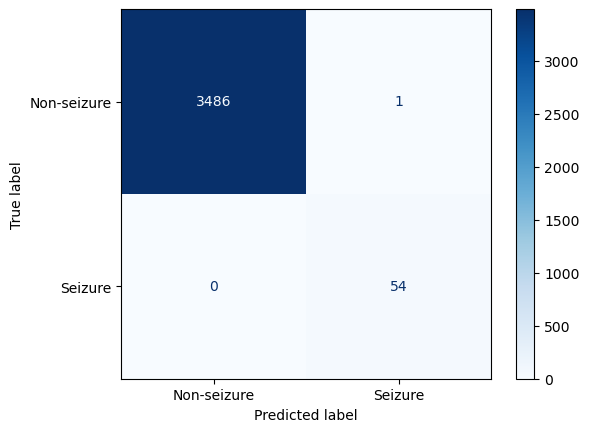

In [21]:
conv_lstm.evaluate()

Results from evaluating test set
> Test Recall: 1.0000, Test Precision: 0.9818

Recall score using 10-second EEG segmentation window exceeds target score of **80%**
Precision, not critical as result will be verified by physician.
Higher recall score at the expense is totally acceptable. Physician will sieve through false positive results.

### Loading stored model

In [14]:
cnn_lstm_model = load_model('seizure_CNN_LSTM.keras')


In [23]:
print(f"Test accuracy {cnn_lstm_model.evaluate(val_balanced_signals, val_balanced_labels, verbose=1)}")

111/111 [==============================] - 0s 4ms/step - loss: 0.6659 - accuracy: 0.6672
Test accuracy [0.66585373878479, 0.6672306656837463]


#### Transformers model
In seizure prediction, capturing temporal dependencies in EEG data is crucial. While **LSTMs** are effective at learning short- to medium-term dependencies, they can still struggle with very long-range dependencies due to issues like the vanishing gradient problem. LSTMs are well-suited for smaller datasets, as they can effectively learn from fewer data points.

**Transformers**, on the other hand, have the advantage of parallelization efficiency. Unlike LSTMs, which process data sequentially, Transformers can process entire sequences simultaneously due to their self-attention mechanism, resulting in faster training and inference, which is important for real-time seizure detection.
CHB-MIT dataset is relatively large by traditional standards in seizure prediction, containing recordings from 24 patients and spanning 23 hours of data for each. Consequently, Transformers are better equipped to model complex, long-term dependencies across longer sequences, making them more effective for large datasets like CHB-MIT.


Feed forward network represents non-linear transformation for each neuron.

if x is input,  f is activation function , w is weight, and b is bias

> computation is given by **f(Wx + b)**


##### Transformer pipeline
Summary of process pipeline from EEG signal input, to seizure prediction output using a transformer model:

1. Input EEG Signals: Shape (size, 23, 2560)
2. Self-Attention Mechanism: Generates contextual embeddings for each electrode signal.
3. Feed-Forward Neural Network: Transforms the contextual embeddings into higher-level features.
4. Pooling Layer: Reduces the dimensionality while retaining important information.
5. Prediction Layer: Outputs the probability of each class (seizure or non-seizure) using softmax.
6. Loss Function: Measures the difference between predictions and actual labels.
7. Backpropagation and Optimization: Updates model parameters to minimize the loss.


In [30]:
# input_shape = (samples,23, 2560)  # (samples, channels, time steps)

# Transformer encoder layer
class Transformer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(Transformer, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # A feed forward network with non linear transformation of features at each neuron
        self.sequential = Sequential([
            Dense(ff_dim, activation="relu"),
            # Each channel is transformed to a dense representation using Dense(embed_dim).
            Dense(embed_dim),
        ])
        self.normalised1 = LayerNormalization(epsilon=1e-6)
        self.normalised2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.normalised1(inputs + attn_output)
        ffn_output = self.sequential(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.normalised2(out1 + ffn_output)

# Build the model
def build_transformer(input_shape, num_heads=4, ff_dim=128, embed_dim=64, num_classes=1):
    inputs = Input(shape=input_shape)

    # Flatten the time series for embedding
    x = Dense(embed_dim)(inputs)  # Create embedding
    x = Transformer(embed_dim, num_heads, ff_dim)(x)

    # Global pooling
    x = GlobalAveragePooling1D()(x)

    # Fully connected output
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation="sigmoid")(x)  # For binary classification

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [31]:

# Load data
# train_10sec contains data loaded from 10sec_signals.npy
# labels_10sec contains data loaded from 10_sec_labels.npy

# input shape is (samples, 23, 2560), however model implicitly handles
# (channels, features) for each sample
input_shape = train_10sec.shape[1:]

# Build  and compile model
model = build_transformer(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall','Precision'])

# Fit and evaluate model
history = model.fit(train_10sec, labels_10sec, epochs=19, batch_size=32, validation_split=0.3)

loss, recall, precision = model.evaluate(train_10sec, labels_10sec)
print(f'Loss: {loss:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}')

Epoch 1/25
259/259 [==============================] - 6s 18ms/step - loss: 0.5591 - recall: 0.0039 - precision: 0.2000 - val_loss: 0.6706 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/25
259/259 [==============================] - 4s 15ms/step - loss: 0.5443 - recall: 0.0025 - precision: 0.6250 - val_loss: 0.7211 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/25
259/259 [==============================] - 4s 15ms/step - loss: 0.5290 - recall: 0.0059 - precision: 0.5455 - val_loss: 0.7046 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/25
259/259 [==============================] - 4s 15ms/step - loss: 0.5235 - recall: 0.0039 - precision: 0.7273 - val_loss: 0.6549 - val_recall: 0.0098 - val_precision: 0.7059
Epoch 5/25
259/259 [==============================] - 4s 15ms/step - loss: 0.5218 - recall: 0.0183 - precision: 0.4933 - val_loss: 0.7127 - val_recall: 0.0057 - val_precision: 0.6364
Epoch 6/25
259/259 [==============================] - 4s 15ms

When trained over 50 epochs validation recall drop after 19th epoch, indicating **overfitting**

To improved model robustness:
 - reduce epoch training to 19 epochs

##### Attention
layers.MultiHeadAttention(num_heads=number of attention heads, key_dim=embedding dimensions) -
1. EEG data is of shape (samples, channels, features). In MultiHeadAttention embedding dimensions define the vector space where the features are mapped too, during embedding. This helps contextual processing of each feature.

2. Number of heads define attention head counts. Each one computes dependencies between time steps, but focuses on different patterns or aspects:
    - Short-term dependencies (e.g., relationships between neighbour time steps).
    - Long-term dependencies (e.g., relationships between distant time steps).
    - Specific signal characteristics (e.g., spikes, rhythms, or repeating patterns).




1. LayerNormalization ensures output of any given layer has mean of 0 and a standard deviation of 1. This accelerates convergence by ensuring activation are of consistent scale.
2. MultiHeadAttention provides a context-aware representation of the input sequence.
3. This representation is then passed through a Feed Forward Network and often a Dense layer to build the final classifier.
4. The dense layer's role is to map the transformed features to the desired output space (e.g., binary or multi-class labels).

The MultiHeadAttention layer computes a new representation of the input (channels and features at each time step). This update is based on its relationship with other time steps in the sequence. This forms the self-attention mechanism.
- Self-Attention: Captures dependencies between time steps in the EEG data. This allows long term dependency, or put into context the entire EEG data.
- Multi-Head: Splits above attention mechanism into multiple subspaces (heads), allowing the model to focus on different types of relationships or features simultaneously.

Concept: The output is a contextualized embedding that reflects input’s features and its relationship with the rest of sequence.
- The output is normalized and combined with the input using a residual connection.
- It is then passed through a Feed Forward Network (Dense layers), which applies transformations to learn non-linear relationships.
- This representation is then reduced to a fixed-size vector using pooling layers (GlobalAveragePooling1D).
- The reduced vector is passed into an output Dense layers, which act as the classifier to predict the desired target (e.g., seizure or no seizure).


#### Convolutional Model
Convolutional networks' learning:
1 are translation-invariant - detectable regardless of position in image
2 takes hierarchical patterns - learns patterns from earlier level

(Chollet, 2019, pp205)
Francois Chollet, Deep Learning with Python, 2 ed. Manning Publication

"They can learn spatial hierarchies of patterns"


In [7]:
# Define the CNN model class
class CNN:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self.build_cnn()

    # Define the CNN architecture
    def build_cnn(self):
        model = Sequential()

        # First convolutional layer (2D)
        model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape, padding='same'))

        # First MaxPooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Second convolutional layer (2D)
        model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))

        # Second MaxPooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Third convolutional layer (2D)
        model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))

        # Global Average Pooling (GAP)
        model.add(GlobalAveragePooling2D())  # Output shape: (None, 256)

        # Dense output layer (binary classification)
        model.add(Dense(1, activation='sigmoid'))  # Output shape: (None, 1)

        return model

    # Compile the model
    def compile_model(self):
        self.model.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['Recall', 'Precision', 'accuracy'])

    # Train the model on training data
    def train(self, train_data, train_labels, epochs=50, batch_size=32, validation_split=0.2):
        history = self.model.fit(train_data,
                                 train_labels,
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_split=validation_split)

        # Plot recall during training
        recall_train = history.history['recall']
        epochs = range(1, len(recall_train) + 1)
        plt.plot(epochs, recall_train, label='Training Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.title('Training Recall vs Epochs')
        plt.show()

        return history

    # Evaluate the model on the test data
    def evaluate(self, test_data, test_labels):
        loss, recall, precision, accuracy = self.model.evaluate(test_data, test_labels)
        print(f'Loss: {loss:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}')

        # Get predictions for confusion matrix
        y_pred = (self.model.predict(test_data) > 0.5).astype(int)

        # Confusion Matrix
        cm = confusion_matrix(test_labels, y_pred)
        cm_labels = ["Non-seizure", "Seizure"]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

        return loss, recall, precision, accuracy

Epoch 1/23
207/207 [==============================] - 912s 4s/step - loss: 0.9204 - recall: 0.1662 - precision: 0.5348 - accuracy: 0.7327 - val_loss: 0.4888 - val_recall: 0.3427 - val_precision: 0.9034 - val_accuracy: 0.8052
Epoch 2/23
207/207 [==============================] - 927s 4s/step - loss: 0.4638 - recall: 0.3773 - precision: 0.8021 - accuracy: 0.8045 - val_loss: 0.4362 - val_recall: 0.3448 - val_precision: 0.9639 - val_accuracy: 0.8125
Epoch 3/23
207/207 [==============================] - 642s 3s/step - loss: 0.4140 - recall: 0.4510 - precision: 0.8239 - accuracy: 0.8237 - val_loss: 0.3818 - val_recall: 0.4978 - val_precision: 0.8652 - val_accuracy: 0.8373
Epoch 4/23
207/207 [==============================] - 326s 2s/step - loss: 0.3846 - recall: 0.4942 - precision: 0.8267 - accuracy: 0.8335 - val_loss: 0.3553 - val_recall: 0.5086 - val_precision: 0.8806 - val_accuracy: 0.8427
Epoch 5/23
207/207 [==============================] - 321s 2s/step - loss: 0.3650 - recall: 0.5230 -

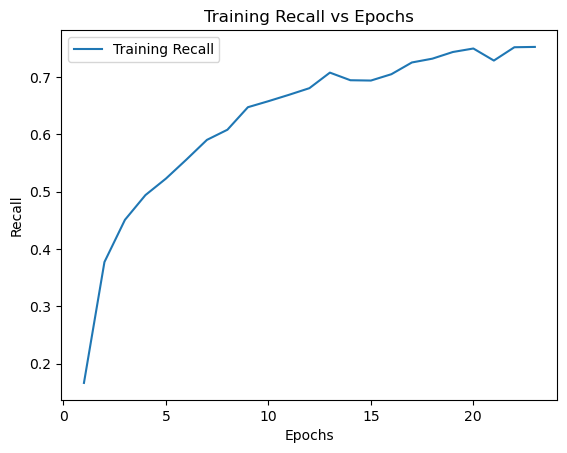

111/111 [==============================] - 71s 638ms/step - loss: 0.2608 - recall: 0.6714 - precision: 0.9194 - accuracy: 0.8921
Loss: 0.2608, Recall: 0.6714, Precision: 0.9194, Accuracy: 0.8921
111/111 [==============================] - 50s 444ms/step


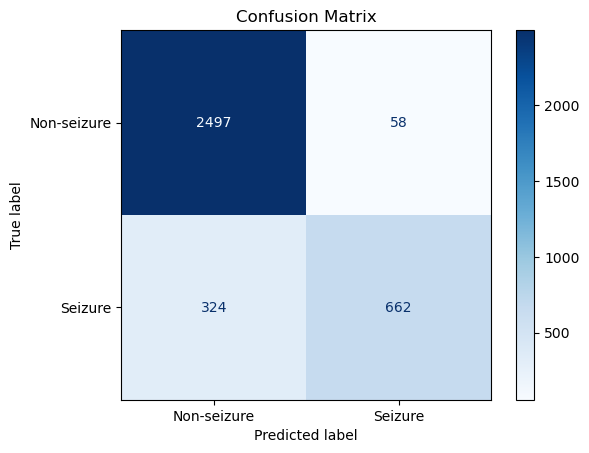

In [8]:
# conv2D input expects batch, channel(height), features(frequency x 20 seconds = 2560) , channel=1 (1D of signal amplitude)
# Define the input shape based on the dataset (for EEG data with 23 channels and 2560 time points)
conv_input_shape = (23, 2560, 1)  # Reshape to include 1 channel

# Initialize the CNN model
cnn_model = CNN(conv_input_shape)

# Compile the model
cnn_model.compile_model()

# Reshape training and test data to match the input shape for Conv2D layer
train_10sec_data_reshaped = train_10sec_data[..., np.newaxis]  # Add the channel dimension
test_10sec_data_reshaped = test_10sec_data[..., np.newaxis]    # Add the channel dimension

# Reshape labels if necessary to match the output shape (samples, 1)
train_10sec_labels = np.expand_dims(train_10sec_labels, axis=-1)
test_10sec_labels = np.expand_dims(test_10sec_labels, axis=-1)

# Train the model
history = cnn_model.train(train_10sec_data_reshaped, train_10sec_labels, epochs=23, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
loss, recall, precision, accuracy = cnn_model.evaluate(test_10sec_data_reshaped, test_10sec_labels)

> Overfitting beyond 19th epochs as training data recall improves slightly, while validation data recall drops

> Best achieved recall score is 75%

In [31]:
print(train_10sec_data_reshaped.shape, test_10sec_data_reshaped.shape)
print(train_10sec_labels.shape,test_10sec_labels.shape )

(8261, 23, 2560, 1) (3541, 23, 2560, 1)
(8261, 1) (3541, 1)


#### Hybrid Convolution Transformer model

The current state of the art in seizure prediction mainly utilizes Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM) networks, and Convolutional Neural Networks (CNNs), which are effective in modeling sequential EEG data by capturing temporal dependencies and extracting relevant features.

An emerging frontier in the field is the hybrid convolution-transformer model, which combines the spatial feature extraction capabilities of CNNs with the temporal strengths of transformers. Such hybrid models (Liu, 2023) have shown promise in improving prediction accuracy by integrating both spatial and temporal information [4].

In [29]:
# Transformer encoder layer
class Transformer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(Transformer, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.sequential = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.normalised1 = LayerNormalization(epsilon=1e-6)
        self.normalised2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.normalised1(inputs + attn_output)
        ffn_output = self.sequential(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.normalised2(out1 + ffn_output)

# CNN-Transformer model
class CNN_Transformer:
    def __init__(self, input_shape, num_filters=32, kernel_size=(3, 3), embed_dim=64, num_heads=4, ff_dim=128, num_classes=1):
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)

        # CNN Block: Extract spatial-temporal features
        x = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, activation="relu", padding="same")(inputs)
        x = Conv2D(filters=self.num_filters * 2, kernel_size=self.kernel_size, activation="relu", padding="same")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = BatchNormalization()(x)

        # Additional CNN layers for deeper feature extraction
        x = Conv2D(filters=self.num_filters * 4, kernel_size=self.kernel_size, activation="relu", padding="same")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = BatchNormalization()(x)

        # Flatten for embedding
        x = Dense(self.embed_dim)(x)

        # Transformer Block
        x = Transformer(embed_dim=self.embed_dim, num_heads=self.num_heads, ff_dim=self.ff_dim)(x)

        # Global pooling
        x = GlobalAveragePooling2D()(x)

        # Fully connected layers for classification
        x = Dense(64, activation="relu")(x)
        x = Dropout(0.3)(x)
        outputs = Dense(self.num_classes, activation="sigmoid")(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model

    def compile(self):
        self.model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['Recall','Precision','accuracy'])

    def train(self, X_train, y_train, batch_size=32, epochs=10, validation_split=None, callbacks=None):
        history = self.model.fit(X_train, y_train, batch_size=batch_size,
                                 epochs=epochs, validation_split=validation_split, callbacks=callbacks)

        # Plot recall during training
        recall_train = history.history['recall']
        epochs = range(1, len(recall_train) + 1)
        plt.plot(epochs, recall_train, label='Training Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()
        plt.title('Training Recall vs Epochs')
        plt.show()

        return history

    def evaluate(self, test_data, test_labels):
        loss, recall, precision, accuracy = self.model.evaluate(test_data, test_labels)
        print(f'Loss: {loss:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}')

        # Get predictions for confusion matrix
        y_predict = (self.model.predict(test_data) > 0.5).astype(int)

        # confusion matrix
        cm = confusion_matrix(test_labels, y_predict)
        cm_labels = ["Non-seizure", "Seizure"]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()
        return loss, recall, precision, accuracy



207/207 [==============================] - 1380s 7s/step - loss: 0.4529 - recall: 0.4399 - precision: 0.7605 - accuracy: 0.8092 - val_loss: 0.5371 - val_recall: 0.3039 - val_precision: 0.9792 - val_accuracy: 0.8028


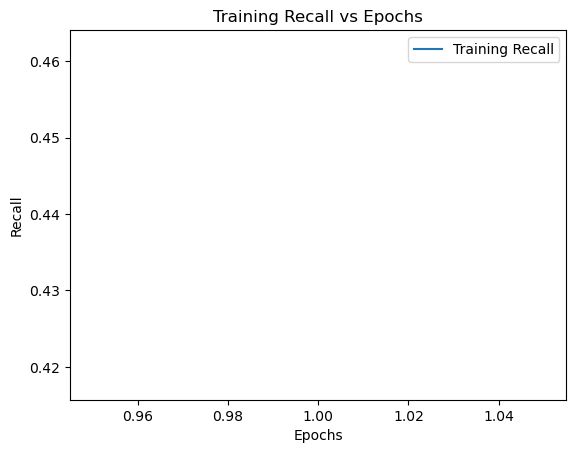

111/111 [==============================] - 290s 3s/step - loss: 0.5489 - recall: 0.2698 - precision: 0.9673 - accuracy: 0.7941
Loss: 0.5489, Recall: 0.2698, Precision: 0.9673, Accuracy: 0.7941
111/111 [==============================] - 285s 3s/step


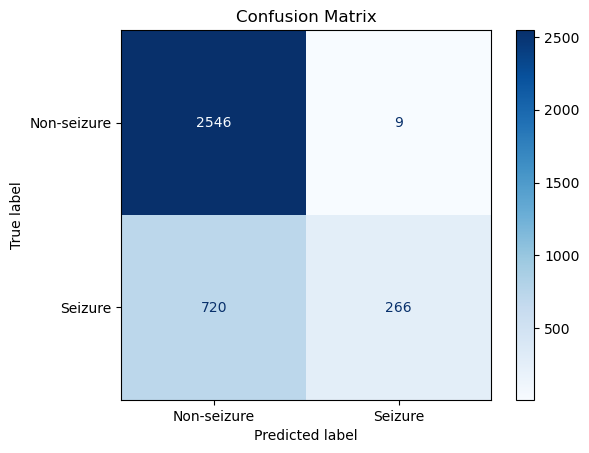

Loss: 0.5489, Recall: 0.2698, Precision: 0.9673, Accuracy: 0.7941


In [30]:
# train_10sec contain data from '10sec_signals.npy'
# labels_10sec  contain data from '10sec_labels.npy'

# 2D convolution needs input (channels=23, timepoints=2560, feature depth=1)
conv_input_shape = (23, 2560, 1)

# Build  and compile model
cnn_t_model = CNN_Transformer(input_shape=conv_input_shape)
cnn_t_model.compile()

# Fit and evaluate model
history = cnn_t_model.train(train_10sec_data_reshaped, train_10sec_labels, epochs=1, batch_size=32, validation_split=0.2)

loss, recall, precision, accuracy = cnn_t_model.evaluate(test_10sec_data_reshaped, test_10sec_labels)
print(f'Loss: {loss:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}')

####Expanation on Convolutional Transformer Model
#### Convolutional Layers (CNN Block)
The convolutional layers capture spatial and temporal dependencies within the EEG signals.
- Multiple layers with increasing filters and pooling reduce dimensionality while retaining essential features.

#### Transformer Encoder
After the convolutional features are extracted, they are passed through a Transformer encoder to:
- Model global dependencies.
- Capture long-range temporal relationships.

#### Hybrid Structure
- The CNN layers act as feature extractors, capturing spatial and temporal information.
- The Transformer layers model relationships between features.
- Combining these methods leverages the strengths of both architectures.

#### Fully Connected Layers
- Final dense layers with a dropout layer reduce overfitting.
- These layers map the output to a binary classification for seizure prediction.

#### Training
- Train the model using binary crossentropy, which is suitable for binary classification tasks.
- Evaluate metrics like sensitivity (recall) to measure the performance of the model.


#### Iteration 3
So far convolution- attention model does best, but still below 80% recall score threshold.
I will combine Bi-LSTM with attention, enabling from short to long term dependencies.

In iteration 2, 3 BiLSTM layer and 2 dense regression layer did not achieve target recall score.
I am using attention to recognise the BiLSTM layers, and an extra dense layer to allow more complex representation.


In [22]:
class BiLSTMAttentionModel:
    def __init__(self, train_shape: tuple, initial_lr: float = 0.0001):
        self.train_shape = train_shape
        self.initial_lr = initial_lr
        self.model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.train_shape[1], self.train_shape[2]))
        bilstm1 = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=L1L2(0, 0.0015)))(inputs)
        do1 = Dropout(0.5)(bilstm1)
        bilstm2 = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=L1L2(0, 0.0015)))(do1)
        att = Attention(32)([bilstm2, bilstm2])
        flat = Flatten()(att)
        dense1 = Dense(128, kernel_regularizer=L1L2(0, 0.0015))(flat)
        dropout3 = Dropout(0.5)(dense1)
        dense2 = Dense(8, kernel_regularizer=L1L2(0, 0.0001))(dropout3)
        outputs = Dense(1, activation='sigmoid')(dense2)

        model = Model(inputs=inputs, outputs=outputs)
        return model

    def compile(self):
        opt = Adam(learning_rate=self.initial_lr)
        self.model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['Recall'])

    def train(self, X_train, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=None):
        # #Check for the presence of the trained weights file
        # model_file_path = 'bilstm_attention_model.h5'
        # if os.path.exists(model_file_path):
        #     print(f'Loading model weights from {model_file_path}')
        #     self.model.load_weights(model_file_path)
        #     return self.model  # Return the model directly if weights are loaded

        history = self.model.fit(X_train, y_train, batch_size=batch_size,
                                 epochs=epochs, validation_split=validation_split, callbacks=callbacks)

        # Plot recall during training
        recall_train = history.history.get('recall', [])
        if recall_train:
            epochs_range = range(1, len(recall_train) + 1)
            plt.plot(epochs_range, recall_train, label='Training Recall')
            plt.xlabel('Epochs')
            plt.ylabel('Recall')
            plt.legend()
            plt.title('Training Recall vs Epochs')
            plt.show()

        return self.model  # Return the model after training

    def evaluate(self, test_data, test_labels):
        # Evaluate model
        results = self.model.evaluate(test_data, test_labels, verbose=0)
        loss = results[0]
        recall = results[1]
        print(f'Loss: {loss:.4f}')
        print(f'Recall: {recall:.4f}')

        # Get predictions for metrics calculation
        y_pred_prob = self.model.predict(test_data)
        y_pred = np.round(y_pred_prob).astype(int)

        # Calculate recall
        recall = recall_score(test_labels, y_pred)
        print(f'Recall: {recall:.4f}')

        # Calculate F1 score
        f1 = f1_score(test_labels, y_pred)
        print(f'F1 Score: {f1:.4f}')

        # Confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        cm_labels = ["Class 0", "Class 1"]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()

        return loss, recall, f1

    def save_model(self, file_path):
        self.model.save(file_path)
        print(f'Model saved to {file_path}')


##### Train and evaluate on 1-second segmentation  window data

Epoch 1/100
942/942 [==============================] - 42s 41ms/step - loss: 1.6279 - recall: 0.2790 - val_loss: 1.3267 - val_recall: 0.3648 - lr: 1.0000e-04
Epoch 2/100
942/942 [==============================] - 216s 229ms/step - loss: 1.1594 - recall: 0.3644 - val_loss: 1.0246 - val_recall: 0.3267 - lr: 1.0000e-04
Epoch 3/100
942/942 [==============================] - 221s 235ms/step - loss: 0.9202 - recall: 0.3953 - val_loss: 0.8574 - val_recall: 0.3904 - lr: 1.0000e-04
Epoch 4/100
942/942 [==============================] - 225s 239ms/step - loss: 0.7763 - recall: 0.4233 - val_loss: 0.7497 - val_recall: 0.4060 - lr: 1.0000e-04
Epoch 5/100
942/942 [==============================] - 222s 236ms/step - loss: 0.6836 - recall: 0.4554 - val_loss: 0.6835 - val_recall: 0.4347 - lr: 1.0000e-04
Epoch 6/100
942/942 [==============================] - 225s 239ms/step - loss: 0.6186 - recall: 0.4840 - val_loss: 0.6326 - val_recall: 0.4197 - lr: 1.0000e-04
Epoch 7/100
942/942 [=====================

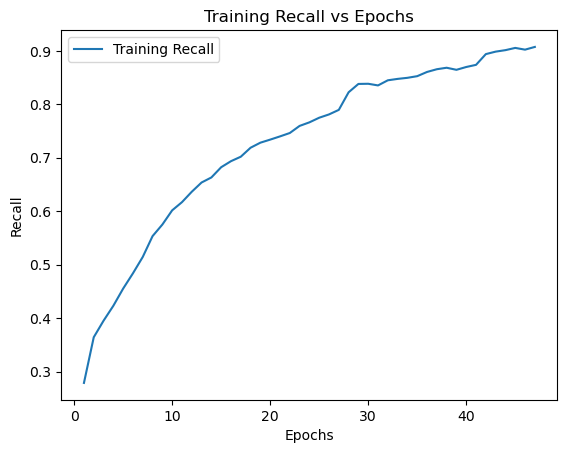

Loss: 0.5221
Recall: 0.5409
253/253 [==============================] - 5s 15ms/step
Recall: 0.5409
F1 Score: 0.6203


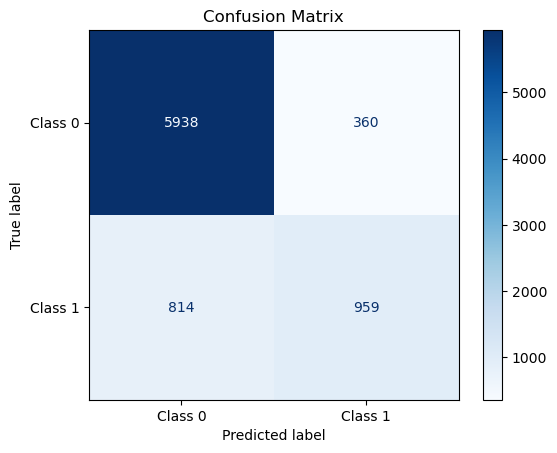

Model saved to bilstm_attention_model_1.h5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 23, 256)]    0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 23, 128)     164352      ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 dropout_2 (Dropout)            (None, 23, 128)      0           ['bidirectional_2[0][0]']        
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 23, 64)  

In [24]:
# Instantiate a BiLSTM with attention model
# 1-second window segmented data
bilstm_attention_model_1 = BiLSTMAttentionModel(train_shape=train_signals.shape, initial_lr=0.0001)

# Compile the model
bilstm_attention_model_1.compile()

# Set up callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001, verbose=1, cooldown=10)

# Train the model
model_1 = bilstm_attention_model_1.train(train_signals_norm, train_labels, batch_size=32, epochs=100, validation_split=0.2, callbacks=[earlystop, reduce_lr])

# Evaluate the model
loss, recall, f1 = bilstm_attention_model_1.evaluate(val_signals_norm, val_labels)

# Save the model to a file
bilstm_attention_model_1.save_model('bilstm_attention_model_1.h5')

# Print model summary
bilstm_attention_model_1.model.summary()

#### Training on 10-second segementation window

Epoch 1/100
187/187 [==============================] - 18s 82ms/step - loss: 2.6225 - recall: 0.1775 - val_loss: 2.4263 - val_recall: 0.2136 - lr: 1.0000e-04
Epoch 2/100
187/187 [==============================] - 14s 74ms/step - loss: 2.2379 - recall: 0.4411 - val_loss: 2.2005 - val_recall: 0.3155 - lr: 1.0000e-04
Epoch 3/100
187/187 [==============================] - 40s 216ms/step - loss: 1.9234 - recall: 0.6485 - val_loss: 2.1088 - val_recall: 0.4078 - lr: 1.0000e-04
Epoch 4/100
187/187 [==============================] - 56s 300ms/step - loss: 1.6678 - recall: 0.8022 - val_loss: 2.1034 - val_recall: 0.3932 - lr: 1.0000e-04
Epoch 5/100
187/187 [==============================] - 57s 304ms/step - loss: 1.4661 - recall: 0.8900 - val_loss: 2.1199 - val_recall: 0.3786 - lr: 1.0000e-04
Epoch 6/100
187/187 [==============================] - 56s 299ms/step - loss: 1.3118 - recall: 0.9432 - val_loss: 2.2269 - val_recall: 0.4320 - lr: 1.0000e-04
Epoch 7/100
187/187 [===========================

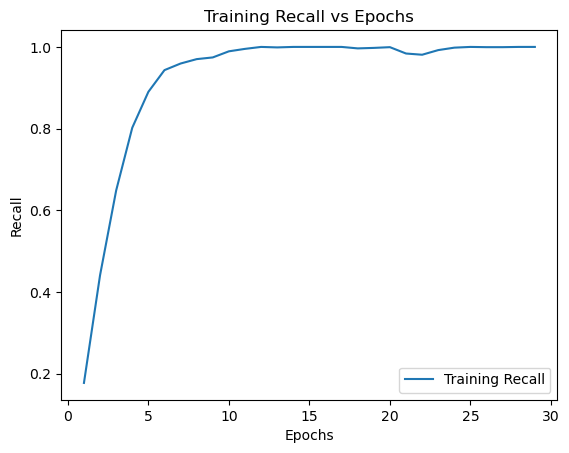

Loss: 2.2000
Recall: 0.3359
59/59 [==============================] - 3s 41ms/step
Recall: 0.3359
F1 Score: 0.4023


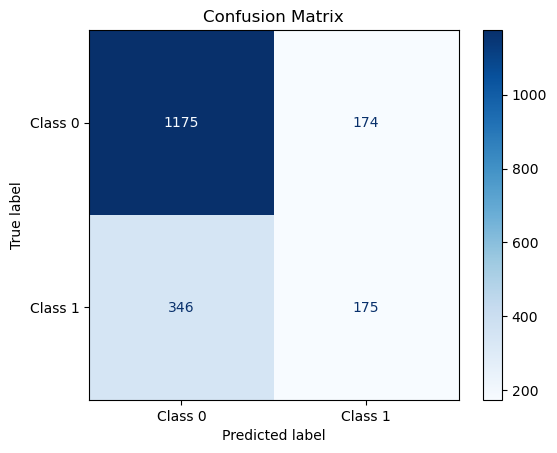

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23, 2560)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 23, 128)      1344000     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 23, 128)      0           ['bidirectional[0][0]']          
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 23, 64)      41216       ['dropout[0][0]']                
 )                                                                                            

In [23]:
1# Instantiate a BiLSTM with attention model
# 10-second window segmented data
bilstm_attention_model = BiLSTMAttentionModel(train_shape=train_10sec_norm.shape, initial_lr=0.0001)

# Compile the model
bilstm_attention_model.compile()

# Set up callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
lower_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001, verbose=1, cooldown=10)

# Train the model
model = bilstm_attention_model.train(train_10sec_norm, train_10sec_labels, batch_size=32, epochs=100, validation_split=0.2, callbacks=[earlystop, lower_lr])

# Evaluate the model
loss, recall, f1 = bilstm_attention_model.evaluate(test_10sec_norm, test_10sec_labels)

# Save the model to a file
#bilstm_attention_model.save_model('bilstm_attention_model.h5')

# Print model summary
bilstm_attention_model.model.summary()


#### Results of hybrid BiLSTM-Attention model
|                  | recall  | val_recall |
|------------------|---------|------------|
| 1-second window  | 0.9073  | 0.6034     |
| 10-seconds window| 0.9938  | 0.4695     |


10-second window achieve high recall values much quicker than 1-second window despite having poorer validation recall.
There is *overfitting*.

Despite using adaptive learning rate, a process to lower learning rate as model improves, model still overfits.
This is due to *insufficient data*. The model is very good at 'memorising' relatively small samples of seizures.

Value dropout has been implemented to reduce overfitting, however model will require many more data samples for robust training.
I will now evaluate models that show robustness with less data.

### Latent Space Clustering

Autoencoders, a type of neural network, are valuable in distinguishing between seizure and normal states. By transforming EEG data into a lower-dimensional latent space, the encoder component of the autoencoder captures critical features.

Through training on dataset with both classes, the autoencoder minimizes reconstruction error, effectively encoding both seizure and normal samples. In this latent space, clusters corresponding to different types of EEG data naturally form. Using clustering algorithms, these distinct clusters can be identified, enabling binary classification of EEG samples based on their latent space representation.

In [15]:
train_10sec_norm.shape



(7480, 23, 2560)

In [24]:
"""Autoencoder Model"""

class AutoencoderModel:
    """Unsupervised learning"""
    def __init__(self, train_shape: tuple, initial_lr: float = 0.0001):
        self.train_shape = train_shape
        self.initial_lr = initial_lr
        self.autoencoder, self.inputs, self.latent_vector = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.train_shape[1], self.train_shape[2]))
        # Encoder - Conv1D gives spatial representation
        # MaxPooling - reduces dimension, and generate auto feature extraction
        encode1 = Conv1D(filters=24, kernel_size=3, activation='relu', padding='same')(inputs)
        encode2 = MaxPooling1D(pool_size=2, padding='same')(encode1)
        encode3 = Conv1D(filters=12, kernel_size=3, activation='relu', padding='same')(encode2)
        encode4 = MaxPooling1D(pool_size=2, padding='same')(encode3)
        # Lower dimension vector - auto generate lower dimension representation
        latent_vector = Conv1D(filters=6, kernel_size=3, activation='relu', padding='same')(encode4)
        # Decoder - reproduce input. Reverses encoding steps
        decode1 = Conv1D(filters=6, kernel_size=3, activation='relu', padding='same')(latent_vector)
        decode2 = UpSampling1D(size=2)(decode1)
        decode3 = Conv1D(filters=12, kernel_size=3, activation='relu', padding='same')(decode2)
        decode4 = UpSampling1D(size=2)(decode3)
        decode5 = Conv1D(filters=24, kernel_size=3, activation='relu', padding='same')(decode4)
        decode6 = Conv1D(filters=24, kernel_size=3, activation='relu', padding='same')(decode5)

        # #Adjust the shape to match the input
        # #Cropping1D removes one dimension at end of timestep
        cropping = Cropping1D((0, 1))(decode6)
        autoencoder_outputs = Conv1D(filters=self.train_shape[2], kernel_size=3, activation='sigmoid', padding='same')(cropping)
        autoencoder_outputs = Dense(self.train_shape[2])(autoencoder_outputs)

        autoencoder = Model(inputs=inputs, outputs=autoencoder_outputs)
        return autoencoder, inputs, latent_vector

    def compile(self):
        optimiser = Adam(learning_rate=self.initial_lr)
        self.autoencoder.compile(optimizer=optimiser, loss='mse')
        return self.autoencoder, self.inputs, self.latent_vector

    def train(self, train_data, target_data, batch_size=32, epochs=10, validation_split=0.2, callbacks=None):
        print(f'X_train shape: {train_data.shape}')
        print(f'y_train shape: {target_data.shape}')
        history = self.autoencoder.fit(train_data, target_data, batch_size=batch_size,
                                       epochs=epochs, validation_split=validation_split, callbacks=callbacks)
        # Plot recall during training
        #'[]' return empty list instead of throwing error
        recall_train = history.history.get('loss', [])
        if recall_train:
            epochs_range = range(1, len(recall_train) + 1)
            plt.plot(epochs_range, recall_train, label='Training Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Training Loss vs Epochs')
            plt.show()

        return history

    def evaluate(self, test_data, test_labels):
        # Evaluate model
        loss = self.autoencoder.evaluate(test_data, test_labels, verbose=0)
        print(f'Loss: {loss:.4f}')

        # # Get predictions for metrics calculation
        # y_pred_prob = self.autoencoder.predict(test_data)
        # y_pred = np.round(y_pred_prob).astype(int)
        #
        # # Calculate recall
        # recall = recall_score(test_labels, y_pred)
        # print(f'Recall: {recall:.4f}')
        #
        # # Calculate F1 score
        # f1 = f1_score(test_labels, y_pred)
        # print(f'F1 Score: {f1:.4f}')
        #
        # # Confusion matrix
        # cm = confusion_matrix(test_labels, y_pred)
        # cm_labels = ["Class 0", "Class 1"]
        # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
        # disp.plot(cmap=plt.cm.Blues)
        # plt.title('Confusion Matrix')
        # plt.show()

        return loss

    def save_model(self, file_path):
        self.autoencoder.save(file_path)
        print(f'Model saved to {file_path}')


X_train shape: (7480, 23, 2560)
y_train shape: (7480, 23, 2560)
Epoch 1/200
187/187 [==============================] - 25s 127ms/step - loss: 1.0112 - accuracy: 3.4149e-04 - recall: 0.0021 - val_loss: 0.9847 - val_accuracy: 4.9407e-04 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/200
187/187 [==============================] - 23s 125ms/step - loss: 1.0061 - accuracy: 4.6501e-04 - recall: 3.3825e-05 - val_loss: 0.9842 - val_accuracy: 5.2313e-04 - val_recall: 1.9799e-05 - lr: 1.0000e-04
Epoch 3/200
187/187 [==============================] - 24s 127ms/step - loss: 1.0055 - accuracy: 3.7055e-04 - recall: 1.8153e-04 - val_loss: 0.9844 - val_accuracy: 3.1969e-04 - val_recall: 4.7795e-05 - lr: 1.0000e-04
Epoch 4/200
187/187 [==============================] - 24s 129ms/step - loss: 1.0050 - accuracy: 5.0134e-04 - recall: 2.8045e-04 - val_loss: 0.9839 - val_accuracy: 2.6157e-04 - val_recall: 2.5237e-04 - lr: 1.0000e-04
Epoch 5/200
187/187 [==============================] - 24s 128ms/step - 

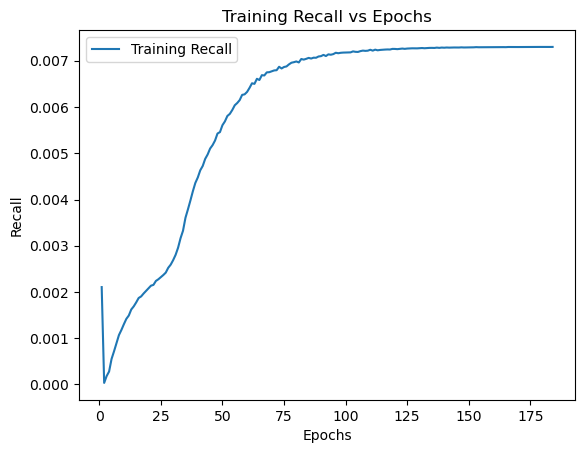

ValueError: in user code:

    File "C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\keras\engine\training.py", line 1668, in test_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\keras\metrics\metrics.py", line 1052, in update_state  **
        return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\mspla\miniconda3\envs\seizurePy3.9\lib\site-packages\keras\utils\metrics_utils.py", line 674, in update_confusion_matrix_variables
        y_pred.shape.assert_is_compatible_with(y_true.shape)

    ValueError: Shapes (None, 23, 2560) and (None,) are incompatible


In [13]:
# Instantiate the model
autoencoder_model = AutoencoderModel(train_10sec_norm.shape, 0.0001)

# Ensure the model is compiled correctly
ae_model, ae_inputs, ae_latent_space = autoencoder_model.compile()

# Set up callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
lower_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001, verbose=1, cooldown=10)

# Train the model
history = autoencoder_model.train(train_10sec_norm, train_10sec_norm, batch_size=32, epochs=200, validation_split=0.2, callbacks=[earlystop, lower_lr])



In [ ]:
# Evaluate the model
loss = autoencoder_model.evaluate(test_10sec_norm, test_10sec_norm)

# Print evaluation results
print(f'Loss: {loss:.4f}')

# Save  model
ae_file_path = 'autoencoder_model.h5'
autoencoder_model.save_model(ae_file_path)

#### Extract latent space from encoder
From trained autoencoder retrieve latent vector's trained weights and biases.

In [14]:
# Export trained model latent space
# Do not repeat training to avoid overfitting.
encoder_copy = Model(inputs=ae_inputs, outputs=ae_latent_space)

for layer in encoder_copy.layers:
    # Set trainable to false to avoid new training
    layer.trainable = False

#### Classification of latent
To separate *seizure* from *non-seizure* representation.

Latent space comprises time steps and convolution filters (2 dimensions). Classification output is binary, 0 or 1.
We have to match the dimensions.

Again we use idea of CNN, MaxPooling and Batch normalisation.

In [15]:
"""
Build seizure  classification model from
latent space representation using autoencoder
"""

class LatentClassifier:
    def __init__(self, encoder, learning_rate=0.001):
        self.encoder = encoder
        self.learning_rate = learning_rate
        self.classification_model = self.build_classifier()

    def build_classifier(self):
        classifier = Sequential()
        classifier.add(self.encoder)
        classifier.add(Conv1D(filters=6, kernel_size=3, padding='same'))
        classifier.add(MaxPooling1D(pool_size=2, padding='same'))
        classifier.add(BatchNormalization())
        classifier.add(Conv1D(filters=4, kernel_size=3, padding='same'))
        classifier.add(MaxPooling1D(pool_size=2, padding='same'))
        classifier.add(BatchNormalization())
        classifier.add(Conv1D(filters=2, kernel_size=3, padding='same'))
        classifier.add(MaxPooling1D(pool_size=2, padding='same'))
        classifier.add(BatchNormalization())
        classifier.add(Flatten())
        classifier.add(Dense(32))
        classifier.add(Dense(1, activation='sigmoid'))

        opt = Adam(learning_rate=self.learning_rate)

        classifier.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy', Recall()])
        return classifier

    def fit(self, train_data, train_labels, batch_size=50, epochs=1250, validation_split=0.2):
        earlystop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
        lower_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001, verbose=1, cooldown=10)

        history_clf = self.classification_model.fit(
            train_data,
            train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1,
            callbacks=[earlystop, lower_lr]
        )
        return history_clf

    def evaluate(self, test_data, test_labels):
        loss, binary_accuracy, recall = self.classification_model.evaluate(test_data, test_labels)
        print(f"Test loss: {loss:.4f} , Test Accuracy: {binary_accuracy:.4f} , Test Recall: {recall:.4f}")

        # Prediction
        y_prediction = (self.classification_model.predict(test_data) > 0.5).astype(int)
        y_true = test_labels

        # Plot confusion matrix
        cm = confusion_matrix(y_true, y_prediction)
        cm_labels = ["Class 0", "Class 1"]
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels).plot(cmap=plt.cm.Blues)
        plt.title('Test Set: Confusion Matrix')
        plt.show()


In [30]:
ae_seizure_classifier = LatentClassifier(encoder_copy)
ae_seizure_classifier.classification_model.summary(())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 6, 6)              185442    
                                                                 
 conv1d_38 (Conv1D)          (None, 6, 6)              114       
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 3, 6)             0         
 g1D)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 3, 6)             24        
 hNormalization)                                                 
                                                                 
 conv1d_39 (Conv1D)          (None, 3, 4)              76        
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 2, 4)            

In [31]:
ae_seizure_classifier.fit(train_10sec_norm, train_10sec_labels)


Epoch 1/1250
120/120 [==============================] - 12s 93ms/step - loss: 0.6128 - binary_accuracy: 0.7141 - recall_5: 0.1518 - val_loss: 0.5880 - val_binary_accuracy: 0.7186 - val_recall_5: 0.0121 - lr: 0.0010
Epoch 2/1250
120/120 [==============================] - 12s 100ms/step - loss: 0.5682 - binary_accuracy: 0.7304 - recall_5: 0.0897 - val_loss: 0.5751 - val_binary_accuracy: 0.7246 - val_recall_5: 0.0170 - lr: 0.0010
Epoch 3/1250
120/120 [==============================] - 9s 72ms/step - loss: 0.5552 - binary_accuracy: 0.7385 - recall_5: 0.1231 - val_loss: 0.5684 - val_binary_accuracy: 0.7273 - val_recall_5: 0.0364 - lr: 0.0010
Epoch 4/1250
120/120 [==============================] - 10s 81ms/step - loss: 0.5490 - binary_accuracy: 0.7411 - recall_5: 0.1572 - val_loss: 0.5720 - val_binary_accuracy: 0.7253 - val_recall_5: 0.0680 - lr: 0.0010
Epoch 5/1250
120/120 [==============================] - 11s 91ms/step - loss: 0.5454 - binary_accuracy: 0.7462 - recall_5: 0.1704 - val_loss

59/59 [==============================] - 0s 3ms/step - loss: 0.5513 - binary_accuracy: 0.7390 - recall_5: 0.0845
Test loss: 0.5513 , Test Accuracy: 0.7390 , Test Recall: 0.0845
59/59 [==============================] - 0s 3ms/step


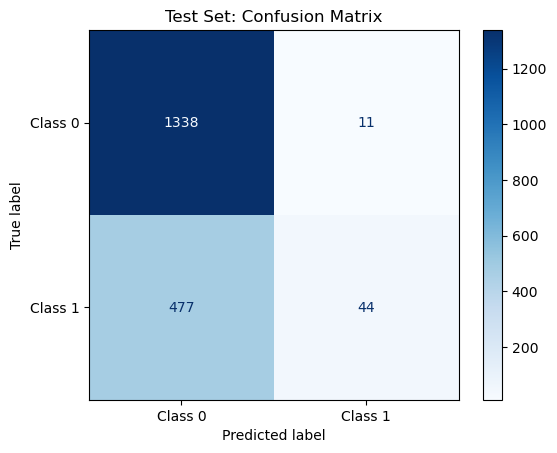

In [32]:
ae_seizure_classifier.evaluate(test_10sec_norm, test_10sec_labels)

#### Results using latent space autoencoder
Evaluation results using unbalanced dataset :
> Test Accuracy: 0.7390 , Test Recall: 0.0845

There is overfitting, that is ***not overcome*** by dropout layers and normalization layers.
This is not retained in notebook.

My 10-sec window data has unbalanced class. Possibility of unbalanced, and smaller sizure set permits model
memorising training set.

For next step, I will improve upon quality of traning data by using a more balanced training data



### Generating a more balanced data from raw data
However this will reduce the number of samples

In [19]:
balanced_signals_path = 'more_balanced_signals.npy'
balanced_labels_path = 'more_balanced_labels.npy'

balanced_signals = np.load(balanced_signals_path)
balanced_labels = np.load(balanced_labels_path)

unique, counts = np.unique(balanced_labels, return_counts=True)
print(f"Non-seizure: {counts[0]} samples, seizure: {counts[1]} samples")
print(f"balanced_signals' data shape is {balanced_signals.shape}")
print(f"balanced_labels shape is {balanced_labels.shape}")
print(f"Proportion of seizure samples = {counts[1]/(counts[1]+counts[0]):.3}%")

Non-seizure: 3558 samples, seizure: 2606 samples
balanced_signals' data shape is (6164, 23, 2560)
balanced_labels shape is (6164,)
Proportion of seizure samples = 0.423%


In [20]:
train_balanced_data, test_balanced_data, train_balanced_label, test_balanced_label =  (
    train_test_split(balanced_signals, balanced_labels, test_size=0.2, shuffle=True, stratify=np.ravel(balanced_labels), random_state=100))

print(f"shape of train_balanced_data: {train_balanced_data.shape}, shape of train_balanced_label: {train_balanced_label.shape}")
print(f"shape of test_balanced_data: {test_balanced_data.shape}, shape of test_balanced_label: {test_balanced_label.shape}")


shape of train_balanced_data: (4931, 23, 2560), shape of train_balanced_label: (4931,)
shape of test_balanced_data: (1233, 23, 2560), shape of test_balanced_label: (1233,)


#### Normalise  data

In [25]:
train_balanced_norm, test_balanced_norm = normalise_data(train_balanced_data, test_balanced_data)

In [26]:
#### Run autoencoder again
# Instantiate the model
autoencoder_balanced = AutoencoderModel(train_balanced_norm.shape, 0.0001)

# Ensure the model is compiled correctly
ae_model, ae_inputs, ae_latent_space = autoencoder_balanced.compile()

# Set up callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
lower_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001, verbose=1, cooldown=10)

# Train the model
history = autoencoder_balanced.train(train_balanced_norm, train_balanced_norm, batch_size=32, epochs=200, validation_split=0.2, callbacks=[earlystop, lower_lr])

# Evaluate the model
# loss = autoencoder_balanced.evaluate(test_balanced_norm, test_balanced_norm)

# Print evaluation results
#print(f'Loss: {loss:.4f}')

# Save  model
ae_file_path = 'autoencoder_balanced.h5'
autoencoder_balanced.save_model(ae_file_path)


X_train shape: (4931, 23, 2560)
y_train shape: (4931, 23, 2560)
Epoch 1/200
124/124 [==============================] - 45s 349ms/step - loss: 1.0046 - val_loss: 1.0224 - lr: 1.0000e-04
Epoch 2/200
124/124 [==============================] - 41s 333ms/step - loss: 0.9970 - val_loss: 1.0228 - lr: 1.0000e-04
Epoch 3/200
124/124 [==============================] - 40s 324ms/step - loss: 0.9963 - val_loss: 1.0227 - lr: 1.0000e-04
Epoch 4/200
124/124 [==============================] - 40s 326ms/step - loss: 0.9953 - val_loss: 1.0214 - lr: 1.0000e-04
Epoch 5/200
124/124 [==============================] - 41s 328ms/step - loss: 0.9942 - val_loss: 1.0205 - lr: 1.0000e-04
Epoch 6/200
124/124 [==============================] - 41s 334ms/step - loss: 0.9935 - val_loss: 1.0212 - lr: 1.0000e-04
Epoch 7/200
124/124 [==============================] - 40s 325ms/step - loss: 0.9932 - val_loss: 1.0204 - lr: 1.0000e-04
Epoch 8/200
124/124 [==============================] - 40s 325ms/step - loss: 0.9927 - va

NameError: name 'loss' is not defined

In [27]:
# Export trained model latent space
# Do not repeat training to avoid overfitting.
encoder_balanced = Model(inputs=ae_inputs, outputs=ae_latent_space)

for layer in encoder_balanced.layers:
    # Set trainable to false to avoid new training
    layer.trainable = False

In [28]:
ae_balanced_classifier = LatentClassifier(encoder_balanced)
ae_balanced_classifier.classification_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_5 (Functional)        (None, 6, 6)              185442    
                                                                 
 conv1d_35 (Conv1D)          (None, 6, 6)              114       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 3, 6)             0         
 g1D)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 3, 6)             24        
 hNormalization)                                                 
                                                                 
 conv1d_36 (Conv1D)          (None, 3, 4)              76        
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 2, 4)            

Epoch 1/1250
79/79 [==============================] - 8s 93ms/step - loss: 0.7042 - binary_accuracy: 0.5624 - recall_4: 0.3218 - val_loss: 0.6507 - val_binary_accuracy: 0.6586 - val_recall_4: 0.2940 - lr: 0.0010
Epoch 2/1250
79/79 [==============================] - 7s 83ms/step - loss: 0.6117 - binary_accuracy: 0.6711 - recall_4: 0.3479 - val_loss: 0.6106 - val_binary_accuracy: 0.6758 - val_recall_4: 0.4329 - lr: 0.0010
Epoch 3/1250
79/79 [==============================] - 6s 81ms/step - loss: 0.5897 - binary_accuracy: 0.6919 - recall_4: 0.4096 - val_loss: 0.5955 - val_binary_accuracy: 0.6869 - val_recall_4: 0.5023 - lr: 0.0010
Epoch 4/1250
79/79 [==============================] - 7s 90ms/step - loss: 0.5887 - binary_accuracy: 0.6983 - recall_4: 0.4537 - val_loss: 0.5936 - val_binary_accuracy: 0.6920 - val_recall_4: 0.4977 - lr: 0.0010
Epoch 5/1250
79/79 [==============================] - 7s 91ms/step - loss: 0.5894 - binary_accuracy: 0.6983 - recall_4: 0.4507 - val_loss: 0.6040 - val_

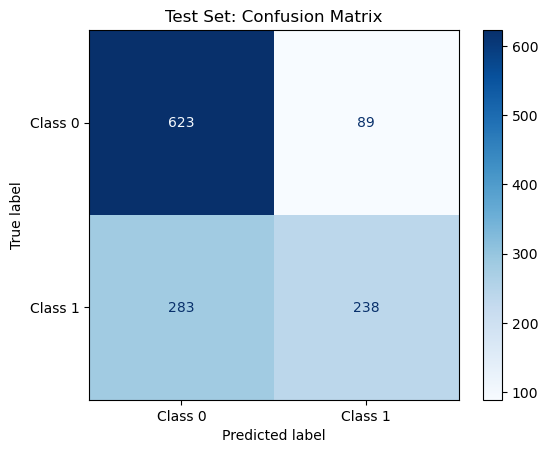

In [29]:
ae_balanced_classifier.fit(train_balanced_norm, train_balanced_label)
ae_balanced_classifier.evaluate(test_balanced_norm, test_balanced_label)

#### Overall results for autoencoder

| Data Type          | Test Accuracy | Test Recall |
|--------------------|---------------|-------------|
| Unbalanced Data    | 0.7390        | 0.0845      |
| More Balanced Data | 0.6983        | 0.4568      |

Unbalanced data has **27.9%** comprising seizure data .<br>
More balanced data has **42.3%** comprising seizure data.


The model early, with use of batch normalisation and dropout layers.


Due to slow training, I opted for manual rather than automated fine tuning.
I ran models separately. Each training with addition of
1. dropout layer
2. normalisation layer

This results in convergence with slightly worse off loss than the base model I kept in Autocoder Class.

The plateau effect is seen with training and testing data. This imply model most likely has insufficient data to train on.
This is not surprising as my dataset has less than 10000 samples per class.

#### Insight
Interesting to use generative AI stype autoencoder and classification to train seizure detection.
> However, much more data is required, and this model is not suitable for current dataset.


### Takeaways afterm 3 sprints

#### Model Performance
Classical machine learning models like Support Vector Machines (SVM) and supervised deep learning models such as Convolutional Neural Networks (CNN) and Bidirectional Long Short-Term Memory (BiLSTM) perform well on the EEG data. However, Transformer-based models and unsupervised Autoencoder models require more data than what is available in the current training set.

#### Class Balance
The balance between seizure and non-seizure samples significantly affects the generalization and robustness of the model. A more balanced dataset (43% seizure, 67% non-seizure) shows substantial improvement compared to a less balanced dataset (27.9% seizure vs. 72.1% non-seizure). The recall score improved from 0.08 to 0.46.


#### Iteration 4
##### Hyperparameter tuning for CNN-Transformer model

In [ ]:
# Hyperparameter tuning class
class HyperparameterTuning:
    def __init__(self, input_shape, param_grid):
        self.input_shape = input_shape
        self.param_grid = param_grid

    def tune(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=10):
        best_model = None
        best_accuracy = 0
        best_params = None

        for num_heads in self.param_grid['num_heads']:
            for ff_dim in self.param_grid['ff_dim']:
                print(f"Training with num_heads={num_heads}, ff_dim={ff_dim}")
                model = CNN_Transformer(
                    input_shape=self.input_shape,
                    num_heads=num_heads,
                    ff_dim=ff_dim
                )
                model.compile()

                callbacks = [
                    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                    ModelCheckpoint(filepath=f'model_heads{num_heads}_ffdim{ff_dim}.h5', save_best_only=True, monitor='val_accuracy', mode='max')
                ]

                history = model.train(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks)
                val_accuracy = max(history.history['val_accuracy'])

                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_model = model.model
                    best_params = {'num_heads': num_heads, 'ff_dim': ff_dim}

        print(f"Best Parameters: {best_params}, Best Validation Accuracy: {best_accuracy}")
        return best_model, best_params

### References

[4] Alzahy, A., Elgammaly, M., Mohammed, H., & Mostafax, H. (2019). 'Optimal EEG Window Size for Neural Seizure Detection'. In 2019 6th International Conference on Modern Control and Automation Systems (MOCAST), pp.  1-6. IEEE.

[1] Badea A., Adam, A. 2021. CHB-MIT-Subdataset, EEG Seizure Analysis Dataset. Available from https://www.kaggle.com/datasets/adibadea/chbmitseizuredataset [Accessed 12 November 2024].

[3] Deepa, B., & Ramesh, K. (2022). Epileptic seizure detection using deep learning through min max scaler normalization. International Journal of Health Sciences, 6(S1), 10981–10996. https://doi.org/10.53730/ijhs.v6nS1.7801

[4] Liu, Z., Li, Y., Zhang, L., & Yang, Y. (2023). Hybrid deep learning model using CNN and Transformer for seizure prediction. IEEE Transactions on Neural Networks and Learning Systems, 34(2), 567-578.

[5] Panch, T. (2019). Key challenges for delivering clinical impact with artificial intelligence. BMC Medicine, 17, pp. 1-10.

[10] Rajkomar, A. (2023). Revolutionizing healthcare: the role of artificial intelligence in clinical practice. BMC Medical Education, 23, pp. 1-15.

[29] [16] Wang, C., Zou, J.Z., Zhang, J., Chen, L.L., & Wang, M. (2011). Recognition of Epileptic EEG Using Support Vector Machines. In Wang, R. & Gu, F. (eds) Advances in Cognitive Neurodynamics (II), Chapter 4, pp. 453-459. Springer, Dordrecht.
